In [1]:
# Load necessary libraries
library(brms)
library(tidyverse)
library(ggplot2)
library(bayesplot)
library(tibble)
library(ggeffects)
library(easystats)
library(DT)
library(dplyr)
library(posterior)

Loading required package: Rcpp

Loading 'brms' package (version 2.22.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:stats’:

    ar


Warning message:
“package ‘ggplot2’ was built under R version 4.5.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
This is bayesplot version 1.12.0

- Online documentation and vignettes at mc-stan.org/bayesp

# Data

In [2]:
df <- read.csv('/Users/aschharwood/kedro_policy_2/organic-policy/data/04_feature/wc_all_sectors_with_compost_search_smoothing.csv')

df$sector_name <- as.factor(df$sector_name)
df$pce_scaled <- df$food_real_pce_2015_dollars/10000
df$centered_pce <- df$pce_scaled - mean(df$pce_scaled, na.rm = TRUE)
df$centered_search_roll <- df$compost_search_3_month_roll - mean(df$compost_search_3_month_roll, na.rm = TRUE)
df$log_pce <- log(df$pce_scaled)
df$centered_logged_pce <- df$log_pce - mean(df$log_pce, na.rm = TRUE)

# Models

### Log-Log with Strong Prior

In [3]:
fit_log_strong_prior <- readRDS('/Users/aschharwood/kedro_policy_2/final_paper_analysis/model_experiments/fit_log_pce_rolling_search_jan_19_no_interaction_strong_prior.rds')

#### Results

In [4]:
summary(fit_log_strong_prior)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(food_tons_clean) ~ adjusted_quant_score_linear + log(pce_scaled) + centered_search + inflation_adjusted_tipping_fee + sector_name + (1 | state) 
   Data: df (Number of observations: 64) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~state (Number of levels: 22) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.20      0.06     0.09     0.33 1.00     2341     2556

Regression Coefficients:
                               Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                         12.33      0.35    11.68    13.02 1.00
adjusted_quant_score_linear       -0.02      0.01    -0.03    -0.01 1.00
logpce_scaled                      1.05      0.07     0.91     1.17 1.00
centered_search                   -0.01      0.00    -0.02     0.00 1.00
inflation_adjusted_tipping_fee   

#### PP_Check

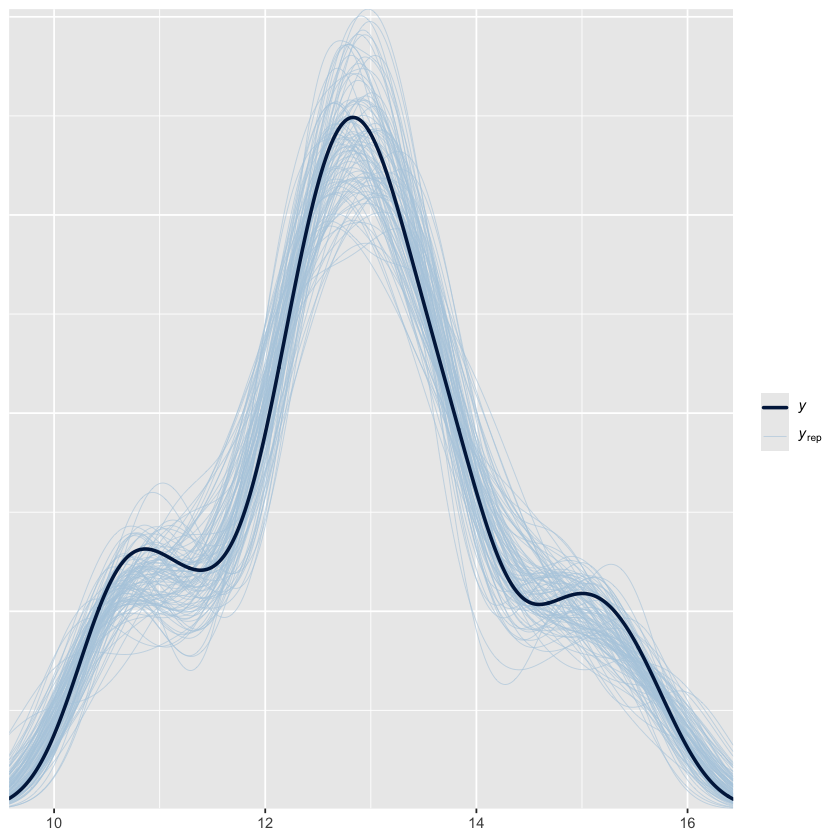

In [5]:
pp_check(fit_log_strong_prior, ndraws = 100)

In [40]:
loo_strong_prior <- loo::loo(fit_log_strong_prior, moment_match = TRUE)

In [41]:
loo_strong_prior


Computed from 8000 by 64 log-likelihood matrix.

         Estimate   SE
elpd_loo     -8.5  6.7
p_loo        16.0  2.9
looic        17.1 13.4
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.4, 1.5]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.

In [8]:


# Function to extract and format model coefficients with ESS
extract_model_table <- function(model, model_name = "Model") {
  # Get summary
  model_summary <- summary(model)
  
  # Extract fixed effects (regression coefficients)
  fixed_effects <- model_summary$fixed
  
  # Create coefficient table
  coef_table <- data.frame(
    Parameter = rownames(fixed_effects),
    Estimate = fixed_effects[, "Estimate"],
    `Std. Error` = fixed_effects[, "Est.Error"],
    `Lower 95% CI` = fixed_effects[, "l-95% CI"],
    `Upper 95% CI` = fixed_effects[, "u-95% CI"],
    Rhat = fixed_effects[, "Rhat"],
    Bulk_ESS = fixed_effects[, "Bulk_ESS"],
    Tail_ESS = fixed_effects[, "Tail_ESS"],
    check.names = FALSE
  )
  
  # Clean up parameter names
  coef_table$Parameter <- gsub("b_", "", coef_table$Parameter)
  coef_table$Parameter <- gsub("_", " ", coef_table$Parameter)
  coef_table$Parameter <- stringr::str_to_title(coef_table$Parameter)
  
  # Replace specific parameter names with more readable versions
  coef_table$Parameter <- case_when(
    coef_table$Parameter == "Adjusted Quant Score Linear" ~ "Policy strength score",
    coef_table$Parameter == "Logpce Scaled" ~ "Log(PCE)",
    coef_table$Parameter == "Centered Search" ~ "Compost search (centered)",
    coef_table$Parameter == "Inflation Adjusted Tipping Fee" ~ "Tipping fee (inflation-adjusted)",
    coef_table$Parameter == "Sector Namesector Ici" ~ "Sector: ICI (vs. Combined)",
    coef_table$Parameter == "Sector Namesector Res" ~ "Sector: Residential (vs. Combined)",
    TRUE ~ coef_table$Parameter
  )
  
  # Extract random effects (if present)
  if (!is.null(model_summary$random)) {
    random_effects <- model_summary$random[[1]]
    random_table <- data.frame(
      Parameter = paste0("SD(", rownames(random_effects), ")"),
      Estimate = random_effects[, "Estimate"],
      `Std. Error` = random_effects[, "Est.Error"],
      `Lower 95% CI` = random_effects[, "l-95% CI"],
      `Upper 95% CI` = random_effects[, "u-95% CI"],
      Rhat = random_effects[, "Rhat"],
      Bulk_ESS = random_effects[, "Bulk_ESS"],
      Tail_ESS = random_effects[, "Tail_ESS"],
      check.names = FALSE
    )
  } else {
    random_table <- NULL
  }
  
  # Extract sigma (residual standard deviation)
  if (!is.null(model_summary$spec_pars)) {
    sigma_table <- data.frame(
      Parameter = "Residual SD (σ)",
      Estimate = model_summary$spec_pars[, "Estimate"],
      `Std. Error` = model_summary$spec_pars[, "Est.Error"],
      `Lower 95% CI` = model_summary$spec_pars[, "l-95% CI"],
      `Upper 95% CI` = model_summary$spec_pars[, "u-95% CI"],
      Rhat = model_summary$spec_pars[, "Rhat"],
      Bulk_ESS = model_summary$spec_pars[, "Bulk_ESS"],
      Tail_ESS = model_summary$spec_pars[, "Tail_ESS"],
      check.names = FALSE
    )
  } else {
    sigma_table <- NULL
  }
  
  # Combine all tables
  if (!is.null(random_table)) {
    full_table <- rbind(coef_table, random_table)
  } else {
    full_table <- coef_table
  }
  
  if (!is.null(sigma_table)) {
    full_table <- rbind(full_table, sigma_table)
  }
  
  # Round numeric columns
  full_table <- full_table %>%
    mutate(
      across(c(Estimate, `Std. Error`, `Lower 95% CI`, `Upper 95% CI`), 
             ~ round(., 3)),
      Rhat = round(Rhat, 2),
      Bulk_ESS = round(Bulk_ESS, 0),
      Tail_ESS = round(Tail_ESS, 0)
    )
  
  return(full_table)
}

# Extract table from your model
model_table <- extract_model_table(fit_log_strong_prior, "Log-log model with strong prior")

# Print the table
print(model_table)

# Export to CSV
write.csv(model_table, "/Users/aschharwood/kedro_policy_2/final_paper_analysis/tables/model_results_table.csv", row.names = FALSE)

                           Parameter Estimate Std. Error Lower 95% CI
1                          Intercept   12.327      0.346       11.682
2              Policy strength score   -0.022      0.005       -0.032
3                           Log(PCE)    1.047      0.068        0.906
4          Compost search (centered)   -0.008      0.005       -0.017
5   Tipping fee (inflation-adjusted)    0.001      0.005       -0.010
6         Sector: ICI (vs. Combined)   -0.866      0.091       -1.046
7 Sector: Residential (vs. Combined)   -0.807      0.091       -0.985
8                  SD(sd(Intercept))    0.200      0.060        0.089
9                    Residual SD (σ)    0.240      0.028        0.192
  Upper 95% CI Rhat Bulk_ESS Tail_ESS
1       13.023    1     3662     4796
2       -0.013    1     8311     6093
3        1.174    1     3182     4165
4        0.001    1     5040     5805
5        0.011    1     3929     5051
6       -0.688    1     4667     5474
7       -0.628    1     4688     5

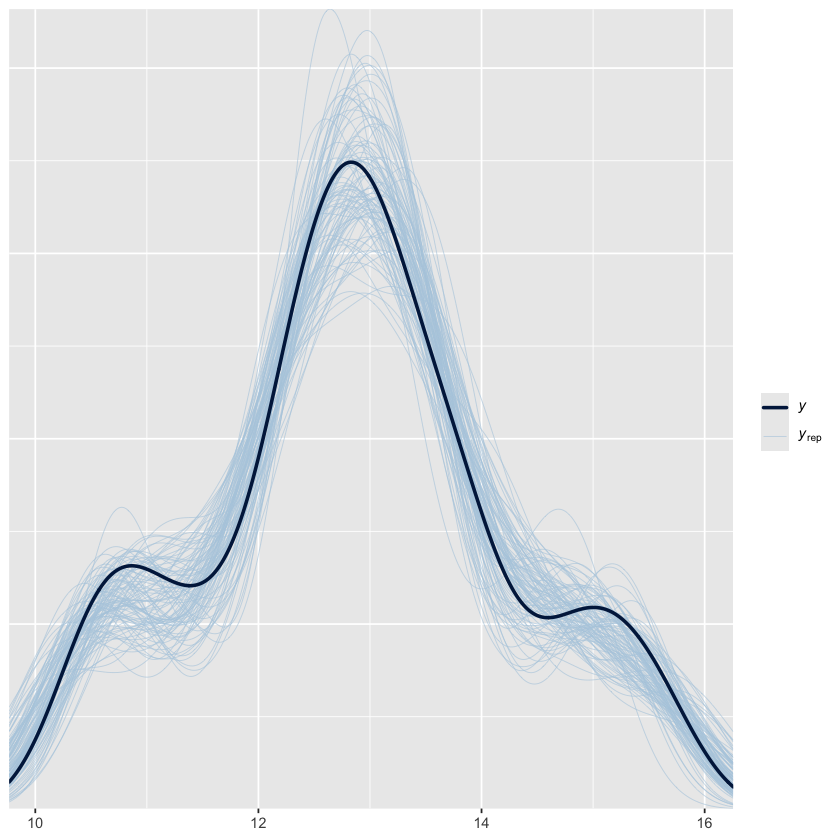

In [9]:
pp_check(fit_log_strong_prior, ndraws = 100)

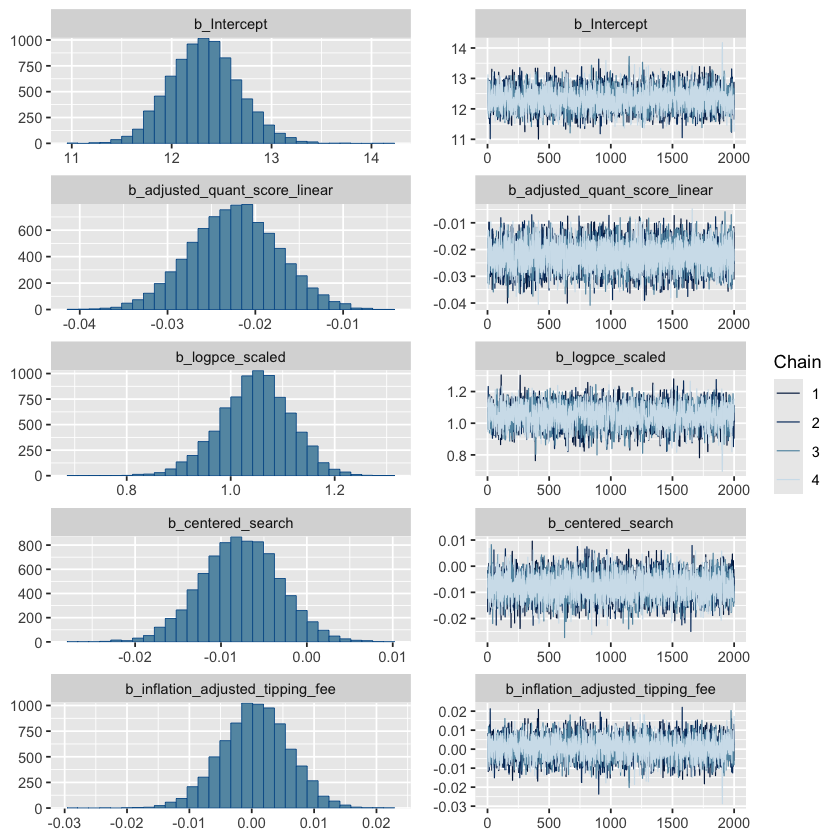

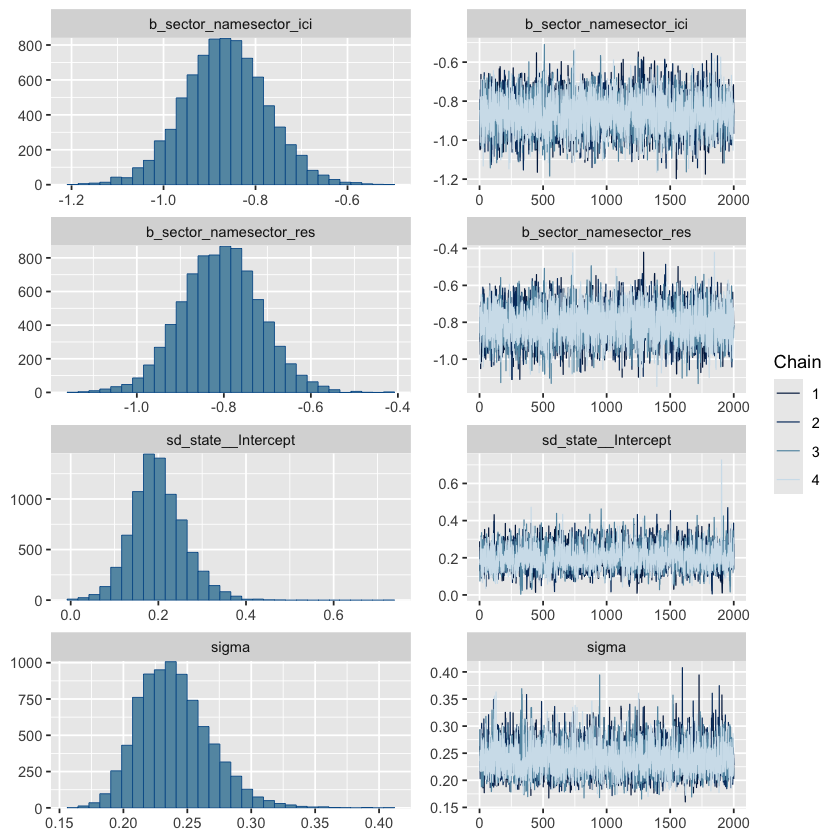

In [10]:
plot(fit_log_strong_prior)

## Log-Log Uninformative Prior

In [11]:
log_log_model <- readRDS("/Users/aschharwood/kedro_policy_2/final_paper_analysis/model_experiments/fit_log_pce_rolling_search_jan_19.rds")


### Results

In [12]:
summary(log_log_model)

 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: log(food_tons_clean) ~ adjusted_quant_score_linear + log(pce_scaled) + centered_search + inflation_adjusted_tipping_fee + sector_name + (1 | state) 
   Data: df (Number of observations: 64) 
  Draws: 4 chains, each with iter = 4000; warmup = 2000; thin = 1;
         total post-warmup draws = 8000

Multilevel Hyperparameters:
~state (Number of levels: 22) 
              Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sd(Intercept)     0.19      0.06     0.08     0.33 1.00     1988     2158

Regression Coefficients:
                               Estimate Est.Error l-95% CI u-95% CI Rhat
Intercept                         12.37      0.33    11.72    13.05 1.00
adjusted_quant_score_linear       -0.02      0.01    -0.03     0.00 1.00
logpce_scaled                      1.05      0.07     0.91     1.17 1.00
centered_search                   -0.01      0.00    -0.02     0.00 1.00
inflation_adjusted_tipping_fee   

In [13]:
# Function to extract and format model coefficients with ESS
extract_model_table <- function(model, model_name = "Model") {
    # Get summary
    model_summary <- summary(model)

    # Extract fixed effects (regression coefficients)
    fixed_effects <- model_summary$fixed

    # Create coefficient table
    coef_table <- data.frame(
        Parameter = rownames(fixed_effects),
        Estimate = fixed_effects[, "Estimate"],
        `Std. Error` = fixed_effects[, "Est.Error"],
        `Lower 95% CI` = fixed_effects[, "l-95% CI"],
        `Upper 95% CI` = fixed_effects[, "u-95% CI"],
        Rhat = fixed_effects[, "Rhat"],
        Bulk_ESS = fixed_effects[, "Bulk_ESS"],
        Tail_ESS = fixed_effects[, "Tail_ESS"],
        check.names = FALSE
    )

    # Clean up parameter names
    coef_table$Parameter <- gsub("b_", "", coef_table$Parameter)
    coef_table$Parameter <- gsub("_", " ", coef_table$Parameter)
    coef_table$Parameter <- stringr::str_to_title(coef_table$Parameter)

    # Replace specific parameter names with more readable versions
    coef_table$Parameter <- case_when(
        coef_table$Parameter == "Adjusted Quant Score Linear" ~ "Policy strength score",
        coef_table$Parameter == "Logpce Scaled" ~ "Log(PCE)",
        coef_table$Parameter == "Centered Search" ~ "Compost search (centered)",
        coef_table$Parameter == "Inflation Adjusted Tipping Fee" ~ "Tipping fee (inflation-adjusted)",
        coef_table$Parameter == "Sector Namesector Ici" ~ "Sector: ICI (vs. Combined)",
        coef_table$Parameter == "Sector Namesector Res" ~ "Sector: Residential (vs. Combined)",
        TRUE ~ coef_table$Parameter
    )

    # Extract random effects (if present)
    if (!is.null(model_summary$random)) {
        random_effects <- model_summary$random[[1]]
        random_table <- data.frame(
            Parameter = paste0("SD(", rownames(random_effects), ")"),
            Estimate = random_effects[, "Estimate"],
            `Std. Error` = random_effects[, "Est.Error"],
            `Lower 95% CI` = random_effects[, "l-95% CI"],
            `Upper 95% CI` = random_effects[, "u-95% CI"],
            Rhat = random_effects[, "Rhat"],
            Bulk_ESS = random_effects[, "Bulk_ESS"],
            Tail_ESS = random_effects[, "Tail_ESS"],
            check.names = FALSE
        )
    } else {
        random_table <- NULL
    }

    # Extract sigma (residual standard deviation)
    if (!is.null(model_summary$spec_pars)) {
        sigma_table <- data.frame(
            Parameter = "Residual SD (σ)",
            Estimate = model_summary$spec_pars[, "Estimate"],
            `Std. Error` = model_summary$spec_pars[, "Est.Error"],
            `Lower 95% CI` = model_summary$spec_pars[, "l-95% CI"],
            `Upper 95% CI` = model_summary$spec_pars[, "u-95% CI"],
            Rhat = model_summary$spec_pars[, "Rhat"],
            Bulk_ESS = model_summary$spec_pars[, "Bulk_ESS"],
            Tail_ESS = model_summary$spec_pars[, "Tail_ESS"],
            check.names = FALSE
        )
    } else {
        sigma_table <- NULL
    }

    # Combine all tables
    if (!is.null(random_table)) {
        full_table <- rbind(coef_table, random_table)
    } else {
        full_table <- coef_table
    }

    if (!is.null(sigma_table)) {
        full_table <- rbind(full_table, sigma_table)
    }

    # Round numeric columns
    full_table <- full_table %>%
        mutate(
            across(
                c(Estimate, `Std. Error`, `Lower 95% CI`, `Upper 95% CI`),
                ~ round(., 3)
            ),
            Rhat = round(Rhat, 2),
            Bulk_ESS = round(Bulk_ESS, 0),
            Tail_ESS = round(Tail_ESS, 0)
        )

    return(full_table)
}

# Extract table from your model
model_table <- extract_model_table(log_log_model, "Log-log model, uninformative prior")

# Print the table
print(model_table)

# Export to CSV
write.csv(model_table, "/Users/aschharwood/kedro_policy_2/final_paper_analysis/tables/model_results_table_uninformative.csv", row.names = FALSE)

                           Parameter Estimate Std. Error Lower 95% CI
1                          Intercept   12.368      0.332       11.724
2              Policy strength score   -0.016      0.010       -0.035
3                           Log(PCE)    1.046      0.066        0.907
4          Compost search (centered)   -0.008      0.005       -0.016
5   Tipping fee (inflation-adjusted)    0.000      0.005       -0.011
6         Sector: ICI (vs. Combined)   -0.870      0.092       -1.049
7 Sector: Residential (vs. Combined)   -0.810      0.091       -0.989
8                  SD(sd(Intercept))    0.194      0.062        0.078
9                    Residual SD (σ)    0.241      0.028        0.194
  Upper 95% CI Rhat Bulk_ESS Tail_ESS
1       13.047    1     4461     4494
2        0.003    1     5827     5509
3        1.171    1     3585     3774
4        0.001    1     6084     6043
5        0.010    1     4601     4479
6       -0.687    1     4989     5757
7       -0.630    1     4927     5

### Diagnostics

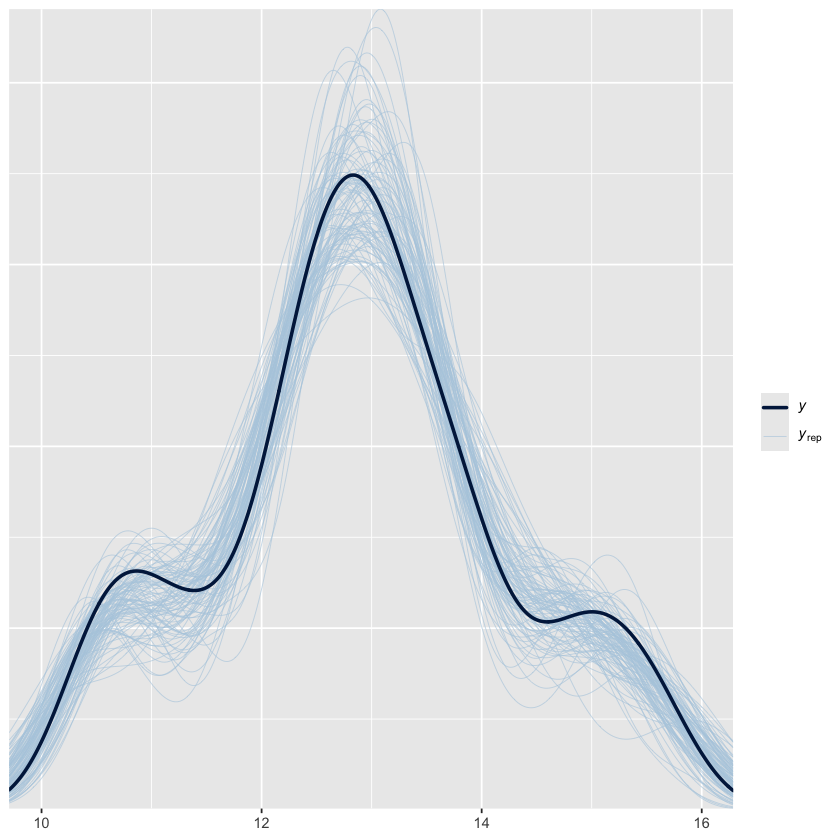

In [44]:
pp_check(log_log_model, ndraws = 100)

In [45]:
loo_log_uninformative <- loo::loo(log_log_model, moment_match = TRUE)

In [46]:
loo_log_uninformative


Computed from 8000 by 64 log-likelihood matrix.

         Estimate   SE
elpd_loo     -9.4  6.6
p_loo        16.5  2.9
looic        18.8 13.1
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.4, 1.5]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.

## Loo Comparison

In [47]:
loo_compare(loo_log_uninformative, loo_strong_prior)

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
fit_log_strong_prior,0.000000,0.0000000,-8.538964,6.687224,16.04838,2.862805,17.07793,13.37445
log_log_model,-0.870984,0.7613912,-9.409948,6.569987,16.51362,2.900218,18.81990,13.13997


## Coefficient Comparison

In [15]:
# Function to extract policy coefficient from a model
extract_beta <- function(fit, model_name) {
  post <- as_draws_df(fit)
  beta <- post$b_adjusted_quant_score_linear

  # If the model did not produce this coefficient, beta will be NULL
  # Also, quantile() on NULL/empty will fail
  if (is.null(beta) || length(beta) == 0) {
    return(NULL)
  }

  data.frame(
    Model = model_name,
    Beta_Median = median(beta),
    CI_Lower = quantile(beta, 0.025),
    CI_Upper = quantile(beta, 0.975),
    P_Negative = mean(beta < 0) * 100
  )
}

beta_list <- list(
  extract_beta(fit_log_strong_prior, "Log Log with Strong Prior"),
  extract_beta(log_log_model, "Log Log with Uninformative Prior")
)

# Remove any NULL elements before calling rbind
beta_list <- beta_list[!sapply(beta_list, is.null)]

if (length(beta_list) == 0) {
  stop("No valid beta estimates produced by extract_beta.")
}

beta_comparison <- do.call(rbind, beta_list)

# Clean up row names
rownames(beta_comparison) <- NULL

# Round for display if dplyr is available
if (requireNamespace("dplyr", quietly = TRUE)) {
  library(dplyr)
  beta_comparison <- beta_comparison %>%
    mutate(
      across(c(Beta_Median, CI_Lower, CI_Upper), ~round(., 4)),
      P_Negative = round(P_Negative, 1)
    )
} else {
  beta_comparison$Beta_Median <- round(beta_comparison$Beta_Median, 4)
  beta_comparison$CI_Lower <- round(beta_comparison$CI_Lower, 4)
  beta_comparison$CI_Upper <- round(beta_comparison$CI_Upper, 4)
  beta_comparison$P_Negative <- round(beta_comparison$P_Negative, 1)
}

print(beta_comparison)

                             Model Beta_Median CI_Lower CI_Upper P_Negative
1        Log Log with Strong Prior     -0.0224  -0.0323  -0.0126      100.0
2 Log Log with Uninformative Prior     -0.0158  -0.0348   0.0032       94.9


`height` was translated to `width`.


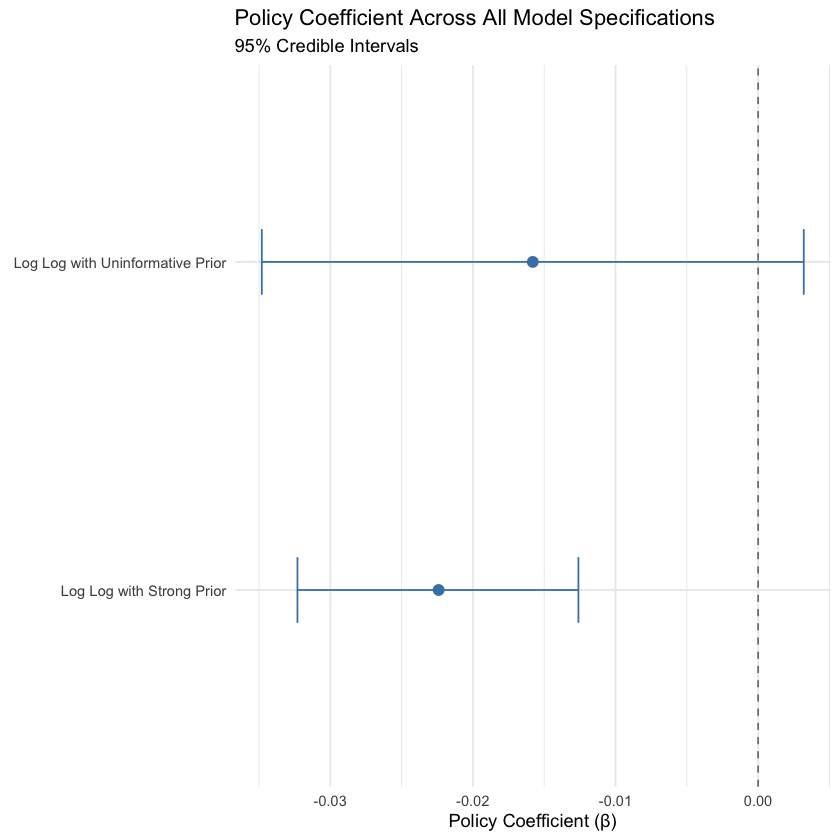

In [17]:
# Add specification grouping for plotting
beta_comparison <- beta_comparison %>%
  mutate(
    Specification = ifelse(grepl("Log-log", Model), "Log-log PCE", "Linear PCE"),
    Prior = case_when(
      grepl("Uninformative", Model) ~ "Uninformative",
      grepl("Weak", Model) ~ "Weak",
      grepl("Strong", Model) ~ "Strong"
    ),
    Distribution = ifelse(grepl("Student-t", Model), "Student-t", "Gaussian")
  )

# Forest plot
ggplot(beta_comparison, aes(x = Beta_Median, y = reorder(Model, Beta_Median))) +
  geom_point(aes(color = Specification, shape = Distribution), size = 3) +
  geom_errorbarh(aes(xmin = CI_Lower, xmax = CI_Upper, color = Specification), height = 0.2) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
  labs(
    title = "Policy Coefficient Across All Model Specifications",
    subtitle = "95% Credible Intervals",
    x = "Policy Coefficient (β)",
    y = NULL
  ) +
  scale_color_manual(values = c("Linear PCE" = "steelblue", "Log-log PCE" = "darkred")) +
  theme_minimal() +
  theme(legend.position = "none")



# Prior Justificiation

WHY WE CHOSE N(-0.025, 0.006) FOR THE POLICY COEFFICIENT

Core insight: Observed reductions and regulator expectations UNDERESTIMATE
true policy effects because they don't account for counterfactual growth.

Without policy intervention, food waste would have INCREASED because:
  - Personal consumption expenditures grew 21-24% during policy periods

  - More economic activity → more food purchased → more waste generated

=== EVIDENCE SOURCE 1: VERMONT ===

Vermont 2023 Waste Composition Study:
  Observed reduction: 13% (raw before/after, no counterfactual)
  Regulator expectation: 7.2% (Science article Table 1)
  PCE growth during policy period: + 24.5 %

If we assume ~50% of PCE growth would have become waste growth:
  Counterfactual waste growth: ~12%
  True policy effect: 13% observed + 12% counterfactual = ~25%
  Implied β at score 16: log(0.75)/16 = -0.018 

=== EVIDENCE SOURCE 2: CALIFORNIA ===

California Waste Characterization Studies (2018-2021):
  Food waste: 5.5M tons → 4.3M 

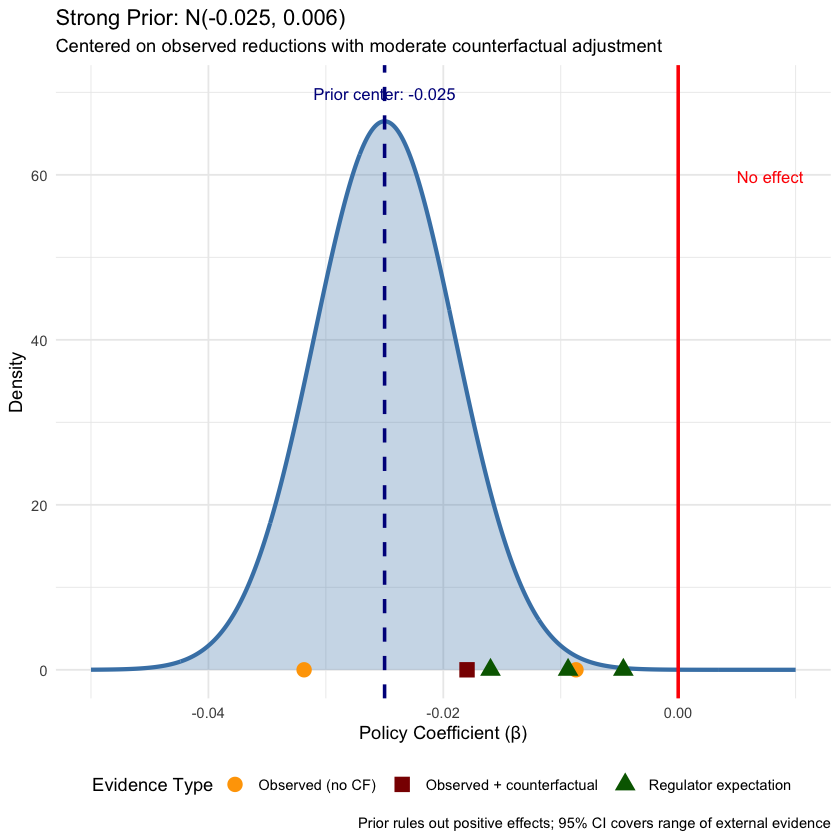

In [16]:
# =============================================================================
# JUSTIFYING THE STRONG PRIOR: N(-0.025, 0.006)
# =============================================================================



# =============================================================================
# THE ARGUMENT IN BRIEF
# =============================================================================

cat("=======================================================================\n")
cat("WHY WE CHOSE N(-0.025, 0.006) FOR THE POLICY COEFFICIENT\n")
cat("=======================================================================\n\n")

cat("Core insight: Observed reductions and regulator expectations UNDERESTIMATE\n")
cat("true policy effects because they don't account for counterfactual growth.\n\n")

cat("Without policy intervention, food waste would have INCREASED because:\n")
cat("  - Personal consumption expenditures grew 21-24% during policy periods\n
")
cat("  - More economic activity → more food purchased → more waste generated\n\n")

# =============================================================================
# EVIDENCE SOURCE 1: VERMONT
# =============================================================================

cat("=== EVIDENCE SOURCE 1: VERMONT ===\n\n")

vt_observed <- 0.13  # 13% reduction from 2023 Waste Study
vt_regulator <- 0.072  # 7.2% regulator expectation
vt_pce_growth <- (3296.4 - 2648.6) / 2648.6  # 24.4%
vt_score <- 16

cat("Vermont 2023 Waste Composition Study:\n")
cat("  Observed reduction: 13% (raw before/after, no counterfactual)\n")
cat("  Regulator expectation: 7.2% (Science article Table 1)\n")
cat("  PCE growth during policy period: +", round(vt_pce_growth * 100, 1), "%\n\n")

cat("If we assume ~50% of PCE growth would have become waste growth:\n")
cat("  Counterfactual waste growth: ~12%\n")
cat("  True policy effect: 13% observed + 12% counterfactual = ~25%\n")
cat("  Implied β at score 16: log(0.75)/16 =", round(log(0.75)/16, 4), "\n\n")

# =============================================================================
# EVIDENCE SOURCE 2: CALIFORNIA
# =============================================================================

cat("=== EVIDENCE SOURCE 2: CALIFORNIA ===\n\n")

ca_observed <- 0.22  # 5.5M → 4.3M tons
ca_regulator <- 0.185  # 18.5% regulator expectation
ca_pce_growth <- (163203.5 - 134936.4) / 134936.4  # 21%
ca_score_change <- 12.8 - 5  # policy intensification during observation

cat("California Waste Characterization Studies (2018-2021):\n")
cat("  Food waste: 5.5M tons → 4.3M tons\n")
cat("  Observed reduction: 22% (raw before/after, no counterfactual)\n")
cat("  Regulator expectation: 18.5% (Science article Table 1)\n")
cat("  PCE growth during policy period: +", round(ca_pce_growth * 100, 1), "%\n\n")

cat("California already EXCEEDS regulator expectations in raw terms.\n")
cat("Once counterfactual adjustment is applied, true effects are even larger.\n\n")

# =============================================================================
# EVIDENCE SOURCE 3: MASSACHUSETTS
# =============================================================================

cat("=== EVIDENCE SOURCE 3: MASSACHUSETTS ===\n\n")

ma_regulator <- 0.098  # 9.8%
ma_score <- 11

cat("Massachusetts 2030 Solid Waste Master Plan:\n")
cat("  Food waste diverted: 100,000 tons (2008) → 310,000 tons (2018)\n")
cat("  Regulator expectation: 9.8% (Science article Table 1)\n")
cat("  Goal: Additional 500,000 tons diverted by 2030\n\n")

# =============================================================================
# THE PROBLEM WITH REGULATOR EXPECTATIONS
# =============================================================================

cat("=== WHY REGULATOR EXPECTATIONS UNDERESTIMATE TRUE EFFECTS ===\n\n")

cat("Regulator expectations range from 7-18%.\n\n")

cat("But these likely underestimate because:\n")
cat("  1. They may use simple before/after comparisons\n")
cat("  2. They may not fully model counterfactual economic growth\n")
cat("  3. Regulators are often conservative to avoid overpromising\n\n")

cat("The Vermont case illustrates this:\n")
cat("  - Regulators expected 7.2% reduction\n")
cat("  - Vermont OBSERVED 13% reduction (nearly 2x expectation)\n")
cat("  - True effect (with counterfactual) is likely ~25%\n\n")

# =============================================================================
# CALIBRATING THE PRIOR CENTER
# =============================================================================

cat("=== CALIBRATING THE PRIOR CENTER ===\n\n")

# Build summary of β estimates
estimates <- tribble(
  ~Source, ~Assumption, ~Implied_Reduction, ~Score, ~Implied_Beta,
  "VT regulator expectation", "As stated", 7.2, 16, log(1-0.072)/16,
  "VT observed", "No counterfactual", 13, 16, log(1-0.13)/16,
  "VT observed + 50% PCE", "Moderate counterfactual", 25, 16, log(1-0.25)/16,
  "CA regulator expectation", "As stated", 18.5, 12.8, log(1-0.185)/12.8,
  "CA observed", "No counterfactual", 22, 7.8, log(1-0.22)/7.8,
  "MA regulator expectation", "As stated", 9.8, 11, log(1-0.098)/11
)

estimates <- estimates %>%
  mutate(Implied_Beta = round(Implied_Beta, 4))

cat("Summary of implied β from different sources:\n\n")
print(estimates %>% select(Source, Assumption, Implied_Beta))

cat("\nRange of estimates:\n")
cat("  Regulator expectations only:     -0.005 to -0.016\n")
cat("  Observed (no counterfactual):    -0.009 to -0.032\n")
cat("  Observed + 50% PCE adjustment:   -0.018 to -0.025\n\n")

cat("We center the prior at β = -0.025 because:\n")
cat("  1. It reflects observed reductions with moderate counterfactual adjustment\n")
cat("  2. It acknowledges that regulator expectations are conservative\n")
cat("  3. It aligns with Vermont's observed 13% + ~12% counterfactual\n")
cat("  4. It is consistent with California EXCEEDING regulator expectations\n\n")

# =============================================================================
# CALIBRATING THE PRIOR SD
# =============================================================================

cat("=== CALIBRATING THE PRIOR SD ===\n\n")

prior_center <- -0.025
prior_sd <- 0.006

cat("We choose SD = 0.006 because:\n\n")

cat("1. It effectively rules out positive effects:\n")
cat("   P(β > 0) =", round(pnorm(0, prior_center, prior_sd, lower.tail = FALSE) * 100, 4), "%\n")
cat("   There is NO plausible mechanism for disposal bans to INCREASE waste.\n\n")

cat("2. The 95% interval covers the range of evidence:\n")
cat("   95% CI: [", round(prior_center - 1.96*prior_sd, 4), ",", 
    round(prior_center + 1.96*prior_sd, 4), "]\n")
cat("   This spans from conservative (regulator-like) to aggressive (full PCE) estimates.\n\n")

cat("3. It allows data to update the prior:\n")
cat("   SD is wide enough that if data strongly disagree, posterior will shift.\n\n")

# =============================================================================
# WHAT THE PRIOR IMPLIES
# =============================================================================

cat("=== WHAT THE PRIOR IMPLIES ===\n\n")

scores <- c(9, 12, 16)
for (s in scores) {
  reduction_median <- (1 - exp(prior_center * s)) * 100
  reduction_lower <- (1 - exp((prior_center + 1.96*prior_sd) * s)) * 100
  reduction_upper <- (1 - exp((prior_center - 1.96*prior_sd) * s)) * 100
  
  cat("At policy score", s, ":\n")
  cat("  Prior expects:", round(reduction_median, 0), "% reduction [",
      round(reduction_lower, 0), "%, ", round(reduction_upper, 0), "%]\n")
}

cat("\nThese predictions align with:\n")
cat("  - Vermont: 13% observed + counterfactual → ~25-30% true effect\n")
cat("  - California: 22% observed + counterfactual → ~30-35% true effect\n")
cat("  - Regulator expectations (7-18%) as lower bound\n\n")

# =============================================================================
# VISUALIZATION
# =============================================================================

cat("=== GENERATING VISUALIZATION ===\n\n")

x <- seq(-0.05, 0.01, length.out = 1000)
prior_density <- dnorm(x, prior_center, prior_sd)

evidence_points <- tibble(
  label = c("VT regulator", "VT observed", "VT + counterfactual",
            "CA regulator", "CA observed", "MA regulator"),
  beta = c(log(1-0.072)/16, log(1-0.13)/16, log(1-0.25)/16,
           log(1-0.185)/12.8, log(1-0.22)/7.8, log(1-0.098)/11),
  type = c("Regulator expectation", "Observed (no CF)", "Observed + counterfactual",
           "Regulator expectation", "Observed (no CF)", "Regulator expectation")
)

ggplot() +
  # Prior distribution
  geom_area(data = tibble(x = x, y = prior_density),
            aes(x = x, y = y), fill = "steelblue", alpha = 0.3) +
  geom_line(data = tibble(x = x, y = prior_density),
            aes(x = x, y = y), color = "steelblue", linewidth = 1.2) +
  
  # Zero line (no effect)
  geom_vline(xintercept = 0, linetype = "solid", color = "red", linewidth = 1) +
  
  # Prior center
  geom_vline(xintercept = prior_center, linetype = "dashed", 
             color = "darkblue", linewidth = 1) +
  
  # Evidence points
  geom_point(data = evidence_points,
             aes(x = beta, y = 0, color = type, shape = type), size = 4) +
  
  # Labels
  annotate("text", x = 0.005, y = max(prior_density) * 0.9,
           label = "No effect", color = "red", hjust = 0, size = 3.5) +
  annotate("text", x = prior_center, y = max(prior_density) * 1.05,
           label = paste("Prior center:", prior_center), 
           color = "darkblue", hjust = 0.5, size = 3.5) +
  
  scale_color_manual(values = c("Regulator expectation" = "darkgreen",
                                 "Observed (no CF)" = "orange",
                                 "Observed + counterfactual" = "darkred")) +
  scale_shape_manual(values = c("Regulator expectation" = 17,
                                 "Observed (no CF)" = 16,
                                 "Observed + counterfactual" = 15)) +
  labs(
    title = "Strong Prior: N(-0.025, 0.006)",
    subtitle = "Centered on observed reductions with moderate counterfactual adjustment",
    x = "Policy Coefficient (β)",
    y = "Density",
    color = "Evidence Type",
    shape = "Evidence Type",
    caption = "Prior rules out positive effects; 95% CI covers range of external evidence"
  ) +
  theme_minimal() +
  theme(legend.position = "bottom")

ggsave("/Users/aschharwood/kedro_policy_2/final_paper_analysis/figures/strong_prior_justification.png",
       width = 10, height = 6, dpi = 300)

# =============================================================================
# SUMMARY
# =============================================================================

cat("\n")
cat("=======================================================================\n")
cat("SUMMARY: JUSTIFICATION FOR N(-0.025, 0.006)\n")
cat("=======================================================================\n\n")

cat("PRIOR CENTER = -0.025\n")
cat("  Based on: Observed state reductions with moderate counterfactual adjustment\n")
cat("  Vermont: 13% observed + ~12% counterfactual = ~25% → β ≈ -0.018\n")
cat("  California: 22% observed over 7.8 score points → β ≈ -0.032\n")
cat("  Midpoint with adjustment: β ≈ -0.025\n\n")

cat("PRIOR SD = 0.006\n")
cat("  P(β > 0) < 0.01% — rules out implausible positive effects\n")
cat("  95% CI [-0.037, -0.013] spans regulator expectations to PCE-adjusted\n")
cat("  Wide enough to let data update the estimate\n\n")

cat("KEY ASSUMPTION:\n")
cat("  Regulator expectations (7-18%) underestimate true effects because\n")
cat("  they don't fully account for counterfactual waste growth from\n")
cat("  rising personal consumption expenditures.\n")
cat("=======================================================================\n")

# % Reduction Prediction Plot

[1] "Strong Prior Model Results:"
  policy_score        model     median     lower      upper
1            0 Strong Prior   0.000000   0.00000   0.000000
2            4 Strong Prior  -8.561696 -12.12261  -4.903795
3            8 Strong Prior -16.390365 -22.77565  -9.567117
4           12 Strong Prior -23.548767 -32.13726 -14.001760
5           16 Strong Prior -30.094289 -40.36400 -18.218938


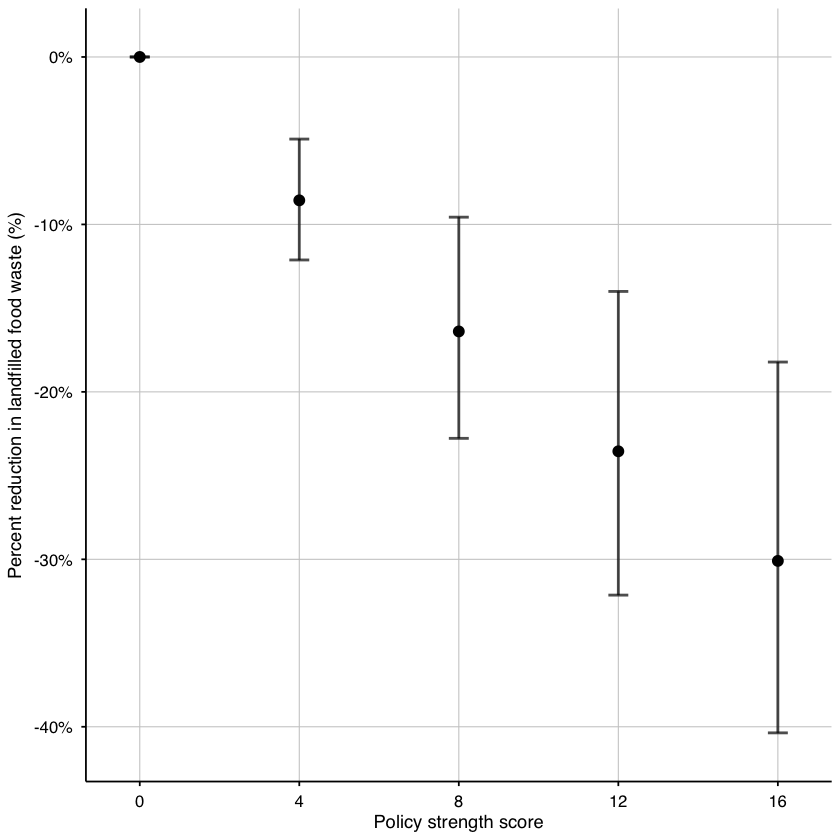

In [40]:
# Policy strength scores to evaluate
policy_scores <- c(0, 4, 8, 12, 16)

# Function to calculate percent reductions using posterior_epred
calculate_percent_reductions_epred <- function(model, policy_scores, df, model_name) {
  # Create prediction data frame with reference values for other covariates
  pred_data <- data.frame(
    adjusted_quant_score_linear = policy_scores,
    pce_scaled = mean(df$pce_scaled, na.rm = TRUE),
    centered_search = 0,  # Centered variable, so 0 is the mean
    inflation_adjusted_tipping_fee = mean(df$inflation_adjusted_tipping_fee, na.rm = TRUE),
    sector_name = levels(df$sector_name)[1]  # Use first level as reference
  )
  
  # Get expected predictions (on log scale)
  # re_formula = NA means ignore random effects (state-level)
  preds_log <- posterior_epred(model, newdata = pred_data, re_formula = NA)
  
  # Transform from log scale to original scale
  preds <- exp(preds_log)
  
  # Calculate percent reduction relative to score 0
  baseline <- preds[, 1]  # Score 0
  percent_reductions <- matrix(NA, nrow = nrow(preds), ncol = ncol(preds))
  
  for(i in 1:ncol(preds)) {
    percent_reductions[, i] <- 100 * (preds[, i] / baseline - 1)
  }
  
  # Create summary data frame
  plot_data <- data.frame(
    policy_score = policy_scores,
    model = model_name,
    median = apply(percent_reductions, 2, median),
    lower = apply(percent_reductions, 2, quantile, 0.025),
    upper = apply(percent_reductions, 2, quantile, 0.975)
  )
  
  return(plot_data)
}

# Calculate for both models
results_strong_prior <- calculate_percent_reductions_epred(
  fit_log_strong_prior, 
  policy_scores, 
  df, 
  "Strong Prior"
)

results_uninformative <- calculate_percent_reductions_epred(
  log_log_model, 
  policy_scores, 
  df, 
  "Uninformative Prior"
)

# ============================================================================
# Plot 1: Strong Prior Model (Publication-ready, no title)
# ============================================================================
# Calculate data range for y-axis (don't extend beyond data)
y_min <- min(results_strong_prior$lower)
y_max <- max(results_strong_prior$upper)
# Add small padding (2% of range)
y_range <- y_max - y_min
y_min_plot <- y_min - 0.02 * y_range
y_max_plot <- y_max + 0.02 * y_range

p1 <- ggplot(results_strong_prior, aes(x = policy_score, y = median)) +
  geom_errorbar(aes(ymin = lower, ymax = upper), 
                width = 0.5, 
                color = "black",
                linewidth = 0.8,
                alpha = 0.7) +
  geom_point(size = 3,
             color = "black",
             shape = 16) +
  scale_x_continuous(breaks = policy_scores,
                     limits = c(-0.5, 16.5)) +
  scale_y_continuous(labels = function(x) paste0(x, "%"),
                     limits = c(y_min_plot, y_max_plot)) +
  labs(
    x = "Policy strength score",
    y = "Percent reduction in landfilled food waste (%)"
    # No title, no subtitle - everything goes in caption
  ) +
  theme_minimal(base_family = "Helvetica") +
  theme(
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(linewidth = 0.3, color = "gray80"),
    axis.line = element_line(color = "black", linewidth = 0.5),
    axis.ticks = element_line(color = "black", linewidth = 0.5),
    axis.text = element_text(size = 10, color = "black"),
    axis.title = element_text(size = 11, color = "black"),
    plot.margin = margin(5, 5, 5, 5, "pt"),
    text = element_text(family = "Helvetica")
  )

print(p1)

# # ============================================================================
# # Plot 2: Uninformative Prior Model (Publication-ready, no title)
# # ============================================================================
# # Calculate data range for y-axis
# y_min2 <- min(results_uninformative$lower)
# y_max2 <- max(results_uninformative$upper)
# y_range2 <- y_max2 - y_min2
# y_min_plot2 <- y_min2 - 0.02 * y_range2
# y_max_plot2 <- y_max2 + 0.02 * y_range2

# p2 <- ggplot(results_uninformative, aes(x = policy_score, y = median)) +
#   geom_errorbar(aes(ymin = lower, ymax = upper), 
#                 width = 0.5, 
#                 color = "black",
#                 linewidth = 0.8,
#                 alpha = 0.7) +
#   geom_point(size = 3,
#              color = "black",
#              shape = 16) +
#   scale_x_continuous(breaks = policy_scores,
#                      limits = c(-0.5, 16.5)) +
#   scale_y_continuous(labels = function(x) paste0(x, "%"),
#                      limits = c(y_min_plot2, y_max_plot2)) +
#   labs(
#     x = "Policy strength score",
#     y = "Percent reduction in landfilled food waste (%)"
#     # No title, no subtitle
#   ) +
#   theme_minimal(base_family = "Helvetica") +
#   theme(
#     panel.grid.minor = element_blank(),
#     panel.grid.major = element_line(linewidth = 0.3, color = "gray80"),
#     axis.line = element_line(color = "black", linewidth = 0.5),
#     axis.ticks = element_line(color = "black", linewidth = 0.5),
#     axis.text = element_text(size = 10, color = "black"),
#     axis.title = element_text(size = 11, color = "black"),
#     plot.margin = margin(5, 5, 5, 5, "pt"),
#     text = element_text(family = "Helvetica")
#   )

# print(p2)

# ============================================================================
# Save as vector graphics for publication
# ============================================================================
# Uncomment these lines when ready to export for publication
# ggsave("figure_strong_prior.pdf", p1, width = 12.1, height = 8, units = "cm", device = cairo_pdf)
# ggsave("figure_uninformative_prior.pdf", p2, width = 12.1, height = 8, units = "cm", device = cairo_pdf)

# Print results
print("Strong Prior Model Results:")
print(results_strong_prior)

# print("\nUninformative Prior Model Results:")
# print(results_uninformative)

### Tons Reduction Plot


=== STRONG PRIOR MODEL ===
Weak Policy (Score = 4):
  Point estimate reduction: 85106 tons
  Point estimate remaining waste: 914548 tons
  95% credible interval: 48150 to 127649 tons reduction

Moderate Policy (Score = 8):
  Point estimate reduction: 162894 tons
  Point estimate remaining waste: 836575 tons
  95% credible interval: 93823 to 240359 tons reduction

Strong Policy (Score = 12):
  Point estimate reduction: 234048 tons
  Point estimate remaining waste: 764961 tons
  95% credible interval: 137159 to 339772 tons reduction

=== UPDATED STATEMENT (Strong Prior Model) ===
Consider a state that disposes of 1,000,000 tons of food waste in landfills annually. A state with a weak policy (score = 4) could expect to see its waste drop by 85106 tons to 914548 tons. A state with a moderate policy (score = 8) could expect to see its waste drop by 162894 tons to 836575 tons. A state with a strong policy (score = 12) could expect to see its waste drop by 234048 tons to 764961 tons. Error b

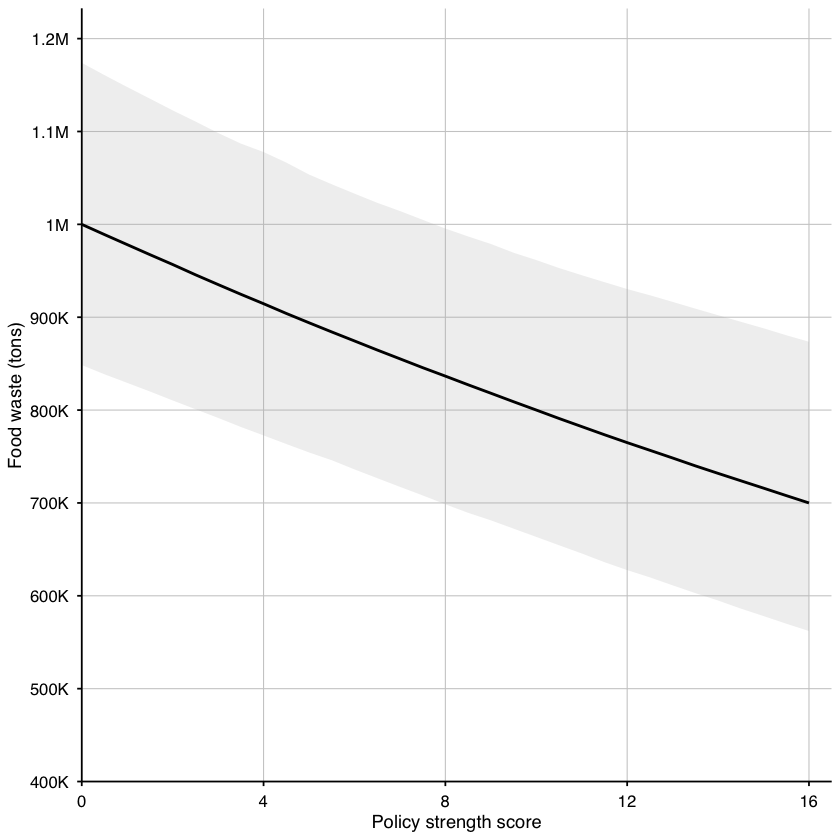

In [45]:
# Policy strength scores to evaluate
policy_scores <- seq(0, 16, by = 0.5)  # Fine grid for smooth line

# Function to calculate predicted food waste with normalization
calculate_predicted_waste <- function(model, policy_scores, df, baseline_tons = 1000000) {
  # Create prediction data frame with reference values for other covariates
  pred_data <- data.frame(
    adjusted_quant_score_linear = policy_scores,
    pce_scaled = mean(df$pce_scaled, na.rm = TRUE),
    centered_search = 0,
    inflation_adjusted_tipping_fee = mean(df$inflation_adjusted_tipping_fee, na.rm = TRUE),
    sector_name = levels(df$sector_name)[1]
  )
  
  # Get expected predictions (on log scale)
  preds_log <- posterior_epred(model, newdata = pred_data, re_formula = NA)
  
  # Transform from log scale to original scale
  preds <- exp(preds_log)
  
  # Normalize to baseline: scale so that score 0 = baseline_tons
  baseline_pred <- preds[, 1]  # Predictions at score 0
  normalization_factor <- baseline_tons / median(baseline_pred)
  
  # Apply normalization to all predictions
  preds_normalized <- preds * normalization_factor
  
  # Calculate summary statistics for each policy score
  plot_data <- data.frame(
    policy_score = policy_scores,
    median = apply(preds_normalized, 2, median),
    lower = apply(preds_normalized, 2, quantile, 0.025),
    upper = apply(preds_normalized, 2, quantile, 0.975)
  )
  
  return(plot_data)
}

# Calculate for both models
results_strong_prior <- calculate_predicted_waste(
  fit_log_strong_prior, 
  policy_scores, 
  df, 
  baseline_tons = 1000000
)

results_uninformative <- calculate_predicted_waste(
  log_log_model, 
  policy_scores, 
  df, 
  baseline_tons = 1000000
)

# ============================================================================
# Function to calculate waste reductions for specific policy scores
# CORRECTED: Calculate reductions from posterior draws, not summary statistics
# Now includes point estimates (median) and predicted remaining waste
# ============================================================================
calculate_waste_reductions <- function(model, policy_scores_vec, df, weak_score = 4, moderate_score = 8, strong_score = 12, baseline_tons = 1000000) {
  # Create prediction data for baseline (score 0), weak, moderate, and strong
  pred_data <- data.frame(
    adjusted_quant_score_linear = c(0, weak_score, moderate_score, strong_score),
    pce_scaled = mean(df$pce_scaled, na.rm = TRUE),
    centered_search = 0,
    inflation_adjusted_tipping_fee = mean(df$inflation_adjusted_tipping_fee, na.rm = TRUE),
    sector_name = levels(df$sector_name)[1]
  )
  
  # Get expected predictions (on log scale)
  preds_log <- posterior_epred(model, newdata = pred_data, re_formula = NA)
  
  # Transform from log scale to original scale
  preds <- exp(preds_log)
  
  # Normalize to baseline
  baseline_pred <- preds[, 1]  # Predictions at score 0
  normalization_factor <- baseline_tons / median(baseline_pred)
  preds_normalized <- preds * normalization_factor
  
  # Extract normalized predictions
  baseline_draws <- preds_normalized[, 1]  # Score 0
  weak_draws <- preds_normalized[, 2]      # Weak score
  moderate_draws <- preds_normalized[, 3]   # Moderate score
  strong_draws <- preds_normalized[, 4]     # Strong score
  
  # Calculate reductions for each posterior draw
  weak_reductions <- baseline_draws - weak_draws
  moderate_reductions <- baseline_draws - moderate_draws
  strong_reductions <- baseline_draws - strong_draws
  
  # Get point estimates (median) and quantiles of reductions
  weak_reduction <- list(
    point_estimate = median(weak_reductions),
    lower = quantile(weak_reductions, 0.025),
    upper = quantile(weak_reductions, 0.975)
  )
  
  moderate_reduction <- list(
    point_estimate = median(moderate_reductions),
    lower = quantile(moderate_reductions, 0.025),
    upper = quantile(moderate_reductions, 0.975)
  )
  
  strong_reduction <- list(
    point_estimate = median(strong_reductions),
    lower = quantile(strong_reductions, 0.025),
    upper = quantile(strong_reductions, 0.975)
  )
  
  # Get point estimates of predicted remaining waste
  weak_remaining <- list(
    point_estimate = median(weak_draws)
  )
  
  moderate_remaining <- list(
    point_estimate = median(moderate_draws)
  )
  
  strong_remaining <- list(
    point_estimate = median(strong_draws)
  )
  
  return(list(
    weak = weak_reduction,
    moderate = moderate_reduction,
    strong = strong_reduction,
    weak_remaining = weak_remaining,
    moderate_remaining = moderate_remaining,
    strong_remaining = strong_remaining,
    weak_score = weak_score,
    moderate_score = moderate_score,
    strong_score = strong_score
  ))
}

# Calculate reductions for both models (using models directly)
reductions_strong <- calculate_waste_reductions(
  fit_log_strong_prior, 
  policy_scores, 
  df, 
  weak_score = 4,
  moderate_score = 8, 
  strong_score = 12, 
  baseline_tons = 1000000
)

reductions_uninformative <- calculate_waste_reductions(
  log_log_model, 
  policy_scores, 
  df, 
  weak_score = 4,
  moderate_score = 8, 
  strong_score = 12, 
  baseline_tons = 1000000
)

# ============================================================================
# Plot 1: Strong Prior Model (Publication-ready)
# ============================================================================
# Calculate data range for y-axis
y_min <- min(results_strong_prior$lower)
y_max <- max(results_strong_prior$upper)
# Set y-axis minimum to 400K
y_min_plot <- 400000
y_max_plot <- y_max + 0.05 * y_max  # Add small padding at top

# Format y-axis breaks - use K and M notation
y_breaks <- pretty(c(y_min_plot, y_max_plot), n = 6)

# Function to format labels as K or M
format_labels <- function(x) {
  ifelse(x >= 1000000,
         paste0(x/1000000, "M"),
         paste0(x/1000, "K"))
}

p1 <- ggplot(results_strong_prior, aes(x = policy_score, y = median)) +
  geom_ribbon(aes(ymin = lower, ymax = upper), 
              alpha = 0.2, 
              fill = "gray70",
              color = NA) +
  geom_line(color = "black", linewidth = 0.8) +
  scale_x_continuous(breaks = c(0, 4, 8, 12, 16),
                     limits = c(-0.5, 16.5),
                     expand = expansion(mult = c(0, 0.05))) +
  scale_y_continuous(
    labels = format_labels,
    breaks = y_breaks,
    limits = c(y_min_plot, y_max_plot),
    expand = expansion(mult = c(0, 0.05))
  ) +
  labs(
    x = "Policy strength score",
    y = "Food waste (tons)"
  ) +
  theme_minimal(base_family = "Helvetica") +
  theme(
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(linewidth = 0.3, color = "gray80"),
    axis.line = element_line(color = "black", linewidth = 0.5),
    axis.ticks = element_line(color = "black", linewidth = 0.5),
    axis.text = element_text(size = 10, color = "black"),
    axis.title = element_text(size = 11, color = "black"),
    plot.margin = margin(5, 5, 5, 5, "pt"),
    text = element_text(family = "Helvetica")
  ) +
  coord_cartesian(xlim = c(0, 16.5), ylim = c(y_min_plot, y_max_plot), expand = FALSE)

print(p1)

# ============================================================================
# # Plot 2: Uninformative Prior Model (Publication-ready)
# # ============================================================================
# # Calculate data range for y-axis
# y_min2 <- min(results_uninformative$lower)
# y_max2 <- max(results_uninformative$upper)
# # Set y-axis minimum to 400K
# y_min_plot2 <- 400000
# y_max_plot2 <- y_max2 + 0.05 * y_max2

# y_breaks2 <- pretty(c(y_min_plot2, y_max_plot2), n = 6)

# p2 <- ggplot(results_uninformative, aes(x = policy_score, y = median)) +
#   geom_ribbon(aes(ymin = lower, ymax = upper), 
#               alpha = 0.2, 
#               fill = "gray70",
#               color = NA) +
#   geom_line(color = "black", linewidth = 0.8) +
#   scale_x_continuous(breaks = c(0, 4, 8, 12, 16),
#                      limits = c(-0.5, 16.5),
#                      expand = expansion(mult = c(0, 0.05))) +
#   scale_y_continuous(
#     labels = format_labels,
#     breaks = y_breaks2,
#     limits = c(y_min_plot2, y_max_plot2),
#     expand = expansion(mult = c(0, 0.05))
#   ) +
#   labs(
#     x = "Policy strength score",
#     y = "Food waste (tons)"
#   ) +
#   theme_minimal(base_family = "Helvetica") +
#   theme(
#     panel.grid.minor = element_blank(),
#     panel.grid.major = element_line(linewidth = 0.3, color = "gray80"),
#     axis.line = element_line(color = "black", linewidth = 0.5),
#     axis.ticks = element_line(color = "black", linewidth = 0.5),
#     axis.text = element_text(size = 10, color = "black"),
#     axis.title = element_text(size = 11, color = "black"),
#     plot.margin = margin(5, 5, 5, 5, "pt"),
#     text = element_text(family = "Helvetica")
#   ) +
#   coord_cartesian(xlim = c(0, 16.5), ylim = c(y_min_plot2, y_max_plot2), expand = FALSE)

# print(p2)

# ============================================================================
# Save as vector graphics for publication
# ============================================================================
# Uncomment these lines when ready to export for publication
# ggsave("figure_food_waste_strong_prior.pdf", p1, width = 12.1, height = 8, units = "cm", device = cairo_pdf)
# ggsave("figure_food_waste_uninformative_prior.pdf", p2, width = 12.1, height = 8, units = "cm", device = cairo_pdf)

# ============================================================================
# Print reduction calculations with point estimates
# ============================================================================
cat("\n=== STRONG PRIOR MODEL ===\n")
cat(sprintf("Weak Policy (Score = %d):\n", reductions_strong$weak_score))
cat(sprintf("  Point estimate reduction: %.0f tons\n", reductions_strong$weak$point_estimate))
cat(sprintf("  Point estimate remaining waste: %.0f tons\n", reductions_strong$weak_remaining$point_estimate))
cat(sprintf("  95%% credible interval: %.0f to %.0f tons reduction\n", 
            reductions_strong$weak$lower, 
            reductions_strong$weak$upper))

cat(sprintf("\nModerate Policy (Score = %d):\n", reductions_strong$moderate_score))
cat(sprintf("  Point estimate reduction: %.0f tons\n", reductions_strong$moderate$point_estimate))
cat(sprintf("  Point estimate remaining waste: %.0f tons\n", reductions_strong$moderate_remaining$point_estimate))
cat(sprintf("  95%% credible interval: %.0f to %.0f tons reduction\n", 
            reductions_strong$moderate$lower, 
            reductions_strong$moderate$upper))

cat(sprintf("\nStrong Policy (Score = %d):\n", reductions_strong$strong_score))
cat(sprintf("  Point estimate reduction: %.0f tons\n", reductions_strong$strong$point_estimate))
cat(sprintf("  Point estimate remaining waste: %.0f tons\n", reductions_strong$strong_remaining$point_estimate))
cat(sprintf("  95%% credible interval: %.0f to %.0f tons reduction\n", 
            reductions_strong$strong$lower, 
            reductions_strong$strong$upper))

# cat("\n=== UNINFORMATIVE PRIOR MODEL ===\n")
# cat(sprintf("Weak Policy (Score = %d):\n", reductions_uninformative$weak_score))
# cat(sprintf("  Point estimate reduction: %.0f tons\n", reductions_uninformative$weak$point_estimate))
# cat(sprintf("  Point estimate remaining waste: %.0f tons\n", reductions_uninformative$weak_remaining$point_estimate))
# cat(sprintf("  95%% credible interval: %.0f to %.0f tons reduction\n", 
#             reductions_uninformative$weak$lower, 
#             reductions_uninformative$weak$upper))

# cat(sprintf("\nModerate Policy (Score = %d):\n", reductions_uninformative$moderate_score))
# cat(sprintf("  Point estimate reduction: %.0f tons\n", reductions_uninformative$moderate$point_estimate))
# cat(sprintf("  Point estimate remaining waste: %.0f tons\n", reductions_uninformative$moderate_remaining$point_estimate))
# cat(sprintf("  95%% credible interval: %.0f to %.0f tons reduction\n", 
#             reductions_uninformative$moderate$lower, 
#             reductions_uninformative$moderate$upper))

# cat(sprintf("\nStrong Policy (Score = %d):\n", reductions_uninformative$strong_score))
# cat(sprintf("  Point estimate reduction: %.0f tons\n", reductions_uninformative$strong$point_estimate))
# cat(sprintf("  Point estimate remaining waste: %.0f tons\n", reductions_uninformative$strong_remaining$point_estimate))
# cat(sprintf("  95%% credible interval: %.0f to %.0f tons reduction\n", 
#             reductions_uninformative$strong$lower, 
#             reductions_uninformative$strong$upper))

# ============================================================================
# Generate updated statement text with point estimates
# ============================================================================
cat("\n=== UPDATED STATEMENT (Strong Prior Model) ===\n")
cat(sprintf("Consider a state that disposes of 1,000,000 tons of food waste in landfills annually. A state with a weak policy (score = %d) could expect to see its waste drop by %.0f tons to %.0f tons. A state with a moderate policy (score = %d) could expect to see its waste drop by %.0f tons to %.0f tons. A state with a strong policy (score = %d) could expect to see its waste drop by %.0f tons to %.0f tons. Error bars in Figure X represent 95%% credible intervals.\n",
            reductions_strong$weak_score,
            round(reductions_strong$weak$point_estimate),
            round(reductions_strong$weak_remaining$point_estimate),
            reductions_strong$moderate_score,
            round(reductions_strong$moderate$point_estimate),
            round(reductions_strong$moderate_remaining$point_estimate),
            reductions_strong$strong_score,
            round(reductions_strong$strong$point_estimate),
            round(reductions_strong$strong_remaining$point_estimate)))

# cat("\n=== UPDATED STATEMENT (Uninformative Prior Model) ===\n")
# cat(sprintf("Consider a state that disposes of 1,000,000 tons of food waste in landfills annually. A state with a weak policy (score = %d) could expect to see its waste drop by %.0f tons to %.0f tons. A state with a moderate policy (score = %d) could expect to see its waste drop by %.0f tons to %.0f tons. A state with a strong policy (score = %d) could expect to see its waste drop by %.0f tons to %.0f tons. Error bars in Figure X represent 95%% credible intervals.\n",
#             reductions_uninformative$weak_score,
#             round(reductions_uninformative$weak$point_estimate),
#             round(reductions_uninformative$weak_remaining$point_estimate),
#             reductions_uninformative$moderate_score,
#             round(reductions_uninformative$moderate$point_estimate),
#             round(reductions_uninformative$moderate_remaining$point_estimate),
#             reductions_uninformative$strong_score,
#             round(reductions_uninformative$strong$point_estimate),
#             round(reductions_uninformative$strong_remaining$point_estimate)))


=== STRONG PRIOR MODEL ===
Weak Policy (Score = 4):
  Waste reduction: 48150 to 127649 tons

Moderate Policy (Score = 8):
  Waste reduction: 93823 to 240359 tons

Strong Policy (Score = 12):
  Waste reduction: 137159 to 339772 tons

=== UPDATED STATEMENT (Strong Prior Model) ===
Consider a state that disposes of 1,000,000 tons of food waste in landfills annually, represented in Figure X. A state with a weak policy (score = 4) could expect to see its waste drop between 48150 and 127649 tons. A state with a moderate policy (score = 8) could expect to see its waste drop between 93823 and 240359 tons. A state with a strong policy (score = 12), on the other hand, could expect to see a drop anywhere between 137159 and 339772 tons.


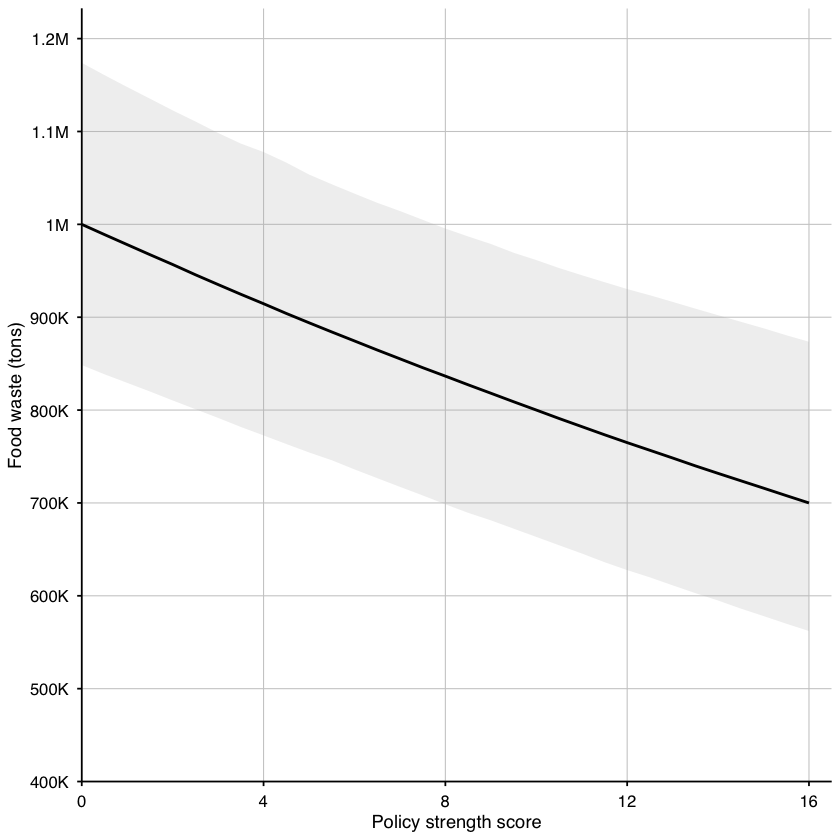

In [44]:
# Policy strength scores to evaluate
policy_scores <- seq(0, 16, by = 0.5)  # Fine grid for smooth line

# Function to calculate predicted food waste with normalization
calculate_predicted_waste <- function(model, policy_scores, df, baseline_tons = 1000000) {
  # Create prediction data frame with reference values for other covariates
  pred_data <- data.frame(
    adjusted_quant_score_linear = policy_scores,
    pce_scaled = mean(df$pce_scaled, na.rm = TRUE),
    centered_search = 0,
    inflation_adjusted_tipping_fee = mean(df$inflation_adjusted_tipping_fee, na.rm = TRUE),
    sector_name = levels(df$sector_name)[1]
  )
  
  # Get expected predictions (on log scale)
  preds_log <- posterior_epred(model, newdata = pred_data, re_formula = NA)
  
  # Transform from log scale to original scale
  preds <- exp(preds_log)
  
  # Normalize to baseline: scale so that score 0 = baseline_tons
  baseline_pred <- preds[, 1]  # Predictions at score 0
  normalization_factor <- baseline_tons / median(baseline_pred)
  
  # Apply normalization to all predictions
  preds_normalized <- preds * normalization_factor
  
  # Calculate summary statistics for each policy score
  plot_data <- data.frame(
    policy_score = policy_scores,
    median = apply(preds_normalized, 2, median),
    lower = apply(preds_normalized, 2, quantile, 0.025),
    upper = apply(preds_normalized, 2, quantile, 0.975)
  )
  
  return(plot_data)
}

# Calculate for both models
results_strong_prior <- calculate_predicted_waste(
  fit_log_strong_prior, 
  policy_scores, 
  df, 
  baseline_tons = 1000000
)

results_uninformative <- calculate_predicted_waste(
  log_log_model, 
  policy_scores, 
  df, 
  baseline_tons = 1000000
)

# ============================================================================
# Function to calculate waste reductions for specific policy scores
# CORRECTED: Calculate reductions from posterior draws, not summary statistics
# Now includes weak policy (score = 4)
# ============================================================================
calculate_waste_reductions <- function(model, policy_scores_vec, df, weak_score = 4, moderate_score = 8, strong_score = 12, baseline_tons = 1000000) {
  # Create prediction data for baseline (score 0), weak, moderate, and strong
  pred_data <- data.frame(
    adjusted_quant_score_linear = c(0, weak_score, moderate_score, strong_score),
    pce_scaled = mean(df$pce_scaled, na.rm = TRUE),
    centered_search = 0,
    inflation_adjusted_tipping_fee = mean(df$inflation_adjusted_tipping_fee, na.rm = TRUE),
    sector_name = levels(df$sector_name)[1]
  )
  
  # Get expected predictions (on log scale)
  preds_log <- posterior_epred(model, newdata = pred_data, re_formula = NA)
  
  # Transform from log scale to original scale
  preds <- exp(preds_log)
  
  # Normalize to baseline
  baseline_pred <- preds[, 1]  # Predictions at score 0
  normalization_factor <- baseline_tons / median(baseline_pred)
  preds_normalized <- preds * normalization_factor
  
  # Extract normalized predictions
  baseline_draws <- preds_normalized[, 1]  # Score 0
  weak_draws <- preds_normalized[, 2]      # Weak score
  moderate_draws <- preds_normalized[, 3]   # Moderate score
  strong_draws <- preds_normalized[, 4]     # Strong score
  
  # Calculate reductions for each posterior draw
  weak_reductions <- baseline_draws - weak_draws
  moderate_reductions <- baseline_draws - moderate_draws
  strong_reductions <- baseline_draws - strong_draws
  
  # Get quantiles of reductions
  weak_reduction <- list(
    lower = quantile(weak_reductions, 0.025),
    upper = quantile(weak_reductions, 0.975)
  )
  
  moderate_reduction <- list(
    lower = quantile(moderate_reductions, 0.025),
    upper = quantile(moderate_reductions, 0.975)
  )
  
  strong_reduction <- list(
    lower = quantile(strong_reductions, 0.025),
    upper = quantile(strong_reductions, 0.975)
  )
  
  return(list(
    weak = weak_reduction,
    moderate = moderate_reduction,
    strong = strong_reduction,
    weak_score = weak_score,
    moderate_score = moderate_score,
    strong_score = strong_score
  ))
}

# Calculate reductions for both models (using models directly)
reductions_strong <- calculate_waste_reductions(
  fit_log_strong_prior, 
  policy_scores, 
  df, 
  weak_score = 4,
  moderate_score = 8, 
  strong_score = 12, 
  baseline_tons = 1000000
)

reductions_uninformative <- calculate_waste_reductions(
  log_log_model, 
  policy_scores, 
  df, 
  weak_score = 4,
  moderate_score = 8, 
  strong_score = 12, 
  baseline_tons = 1000000
)

# ============================================================================
# Plot 1: Strong Prior Model (Publication-ready)
# ============================================================================
# Calculate data range for y-axis
y_min <- min(results_strong_prior$lower)
y_max <- max(results_strong_prior$upper)
# Set y-axis minimum to 400K
y_min_plot <- 400000
y_max_plot <- y_max + 0.05 * y_max  # Add small padding at top

# Format y-axis breaks - use K and M notation
y_breaks <- pretty(c(y_min_plot, y_max_plot), n = 6)

# Function to format labels as K or M
format_labels <- function(x) {
  ifelse(x >= 1000000,
         paste0(x/1000000, "M"),
         paste0(x/1000, "K"))
}

p1 <- ggplot(results_strong_prior, aes(x = policy_score, y = median)) +
  geom_ribbon(aes(ymin = lower, ymax = upper), 
              alpha = 0.2, 
              fill = "gray70",
              color = NA) +
  geom_line(color = "black", linewidth = 0.8) +
  scale_x_continuous(breaks = c(0, 4, 8, 12, 16),
                     limits = c(-0.5, 16.5),
                     expand = expansion(mult = c(0, 0.05))) +
  scale_y_continuous(
    labels = format_labels,
    breaks = y_breaks,
    limits = c(y_min_plot, y_max_plot),
    expand = expansion(mult = c(0, 0.05))
  ) +
  labs(
    x = "Policy strength score",
    y = "Food waste (tons)"
  ) +
  theme_minimal(base_family = "Helvetica") +
  theme(
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(linewidth = 0.3, color = "gray80"),
    axis.line = element_line(color = "black", linewidth = 0.5),
    axis.ticks = element_line(color = "black", linewidth = 0.5),
    axis.text = element_text(size = 10, color = "black"),
    axis.title = element_text(size = 11, color = "black"),
    plot.margin = margin(5, 5, 5, 5, "pt"),
    text = element_text(family = "Helvetica")
  ) +
  coord_cartesian(xlim = c(0, 16.5), ylim = c(y_min_plot, y_max_plot), expand = FALSE)

print(p1)

# ============================================================================
# # Plot 2: Uninformative Prior Model (Publication-ready)
# # ============================================================================
# # Calculate data range for y-axis
# y_min2 <- min(results_uninformative$lower)
# y_max2 <- max(results_uninformative$upper)
# # Set y-axis minimum to 400K
# y_min_plot2 <- 400000
# y_max_plot2 <- y_max2 + 0.05 * y_max2

# y_breaks2 <- pretty(c(y_min_plot2, y_max_plot2), n = 6)

# p2 <- ggplot(results_uninformative, aes(x = policy_score, y = median)) +
#   geom_ribbon(aes(ymin = lower, ymax = upper), 
#               alpha = 0.2, 
#               fill = "gray70",
#               color = NA) +
#   geom_line(color = "black", linewidth = 0.8) +
#   scale_x_continuous(breaks = c(0, 4, 8, 12, 16),
#                      limits = c(-0.5, 16.5),
#                      expand = expansion(mult = c(0, 0.05))) +
#   scale_y_continuous(
#     labels = format_labels,
#     breaks = y_breaks2,
#     limits = c(y_min_plot2, y_max_plot2),
#     expand = expansion(mult = c(0, 0.05))
#   ) +
#   labs(
#     x = "Policy strength score",
#     y = "Food waste (tons)"
#   ) +
#   theme_minimal(base_family = "Helvetica") +
#   theme(
#     panel.grid.minor = element_blank(),
#     panel.grid.major = element_line(linewidth = 0.3, color = "gray80"),
#     axis.line = element_line(color = "black", linewidth = 0.5),
#     axis.ticks = element_line(color = "black", linewidth = 0.5),
#     axis.text = element_text(size = 10, color = "black"),
#     axis.title = element_text(size = 11, color = "black"),
#     plot.margin = margin(5, 5, 5, 5, "pt"),
#     text = element_text(family = "Helvetica")
#   ) +
#   coord_cartesian(xlim = c(0, 16.5), ylim = c(y_min_plot2, y_max_plot2), expand = FALSE)

# print(p2)

# ============================================================================
# Save as vector graphics for publication
# ============================================================================
# Uncomment these lines when ready to export for publication
# ggsave("figure_food_waste_strong_prior.pdf", p1, width = 12.1, height = 8, units = "cm", device = cairo_pdf)
# ggsave("figure_food_waste_uninformative_prior.pdf", p2, width = 12.1, height = 8, units = "cm", device = cairo_pdf)

# ============================================================================
# Print reduction calculations
# ============================================================================
cat("\n=== STRONG PRIOR MODEL ===\n")
cat(sprintf("Weak Policy (Score = %d):\n", reductions_strong$weak_score))
cat(sprintf("  Waste reduction: %.0f to %.0f tons\n", 
            reductions_strong$weak$lower, 
            reductions_strong$weak$upper))

cat(sprintf("\nModerate Policy (Score = %d):\n", reductions_strong$moderate_score))
cat(sprintf("  Waste reduction: %.0f to %.0f tons\n", 
            reductions_strong$moderate$lower, 
            reductions_strong$moderate$upper))

cat(sprintf("\nStrong Policy (Score = %d):\n", reductions_strong$strong_score))
cat(sprintf("  Waste reduction: %.0f to %.0f tons\n", 
            reductions_strong$strong$lower, 
            reductions_strong$strong$upper))

# cat("\n=== UNINFORMATIVE PRIOR MODEL ===\n")
# cat(sprintf("Weak Policy (Score = %d):\n", reductions_uninformative$weak_score))
# cat(sprintf("  Waste reduction: %.0f to %.0f tons\n", 
#             reductions_uninformative$weak$lower, 
#             reductions_uninformative$weak$upper))

# cat(sprintf("\nModerate Policy (Score = %d):\n", reductions_uninformative$moderate_score))
# cat(sprintf("  Waste reduction: %.0f to %.0f tons\n", 
#             reductions_uninformative$moderate$lower, 
#             reductions_uninformative$moderate$upper))

# cat(sprintf("\nStrong Policy (Score = %d):\n", reductions_uninformative$strong_score))
# cat(sprintf("  Waste reduction: %.0f to %.0f tons\n", 
#             reductions_uninformative$strong$lower, 
#             reductions_uninformative$strong$upper))

# ============================================================================
# Generate updated statement text
# ============================================================================
cat("\n=== UPDATED STATEMENT (Strong Prior Model) ===\n")
cat(sprintf("Consider a state that disposes of 1,000,000 tons of food waste in landfills annually, represented in Figure X. A state with a weak policy (score = %d) could expect to see its waste drop between %.0f and %.0f tons. A state with a moderate policy (score = %d) could expect to see its waste drop between %.0f and %.0f tons. A state with a strong policy (score = %d), on the other hand, could expect to see a drop anywhere between %.0f and %.0f tons.\n",
            reductions_strong$weak_score,
            round(reductions_strong$weak$lower),
            round(reductions_strong$weak$upper),
            reductions_strong$moderate_score,
            round(reductions_strong$moderate$lower),
            round(reductions_strong$moderate$upper),
            reductions_strong$strong_score,
            round(reductions_strong$strong$lower),
            round(reductions_strong$strong$upper)))

# cat("\n=== UPDATED STATEMENT (Uninformative Prior Model) ===\n")
# cat(sprintf("Consider a state that disposes of 1,000,000 tons of food waste in landfills annually, represented in Figure X. A state with a weak policy (score = %d) could expect to see its waste drop between %.0f and %.0f tons. A state with a moderate policy (score = %d) could expect to see its waste drop between %.0f and %.0f tons. A state with a strong policy (score = %d), on the other hand, could expect to see a drop anywhere between %.0f and %.0f tons.\n",
#             reductions_uninformative$weak_score,
#             round(reductions_uninformative$weak$lower),
#             round(reductions_uninformative$weak$upper),
#             reductions_uninformative$moderate_score,
#             round(reductions_uninformative$moderate$lower),
#             round(reductions_uninformative$moderate$upper),
#             reductions_uninformative$strong_score,
#             round(reductions_uninformative$strong$lower),
#             round(reductions_uninformative$strong$upper)))

In [15]:
# Load libraries
library(brms)
library(posterior)

# Function to extract percent change per unit from model
extract_percent_change_per_unit <- function(model, model_name) {
  # Extract posterior draws of the coefficient
  post <- as_draws_df(model)
  beta <- post$b_adjusted_quant_score_linear
  
  # Convert coefficient to percent change per unit
  # For log-log model: percent_change = (exp(beta) - 1) * 100
  percent_change <- (exp(beta) - 1) * 100
  
  # Calculate summary statistics
  results <- data.frame(
    Model = model_name,
    Median_Percent = median(percent_change),
    Lower_95CI = quantile(percent_change, 0.025),
    Upper_95CI = quantile(percent_change, 0.975),
    Mean_Percent = mean(percent_change)
  )
  
  return(results)
}

# Extract for both models
strong_prior_results <- extract_percent_change_per_unit(
  fit_log_strong_prior, 
  "Strong Prior"
)

uninformative_results <- extract_percent_change_per_unit(
  log_log_model, 
  "Uninformative Prior"
)

# Combine results
all_results <- rbind(strong_prior_results, uninformative_results)

# Print results
print("Percent Change per Unit Increase in Policy Strength:")
print(all_results)

# Format for statement (using Strong Prior model as example)
strong_prior_lower <- round(abs(strong_prior_results$Lower_95CI), 1)
strong_prior_upper <- round(abs(strong_prior_results$Upper_95CI), 1)

cat("\n")
cat("Updated statement (Strong Prior Model):\n")
cat("Our analysis finds a negative relationship between the strength of organic waste disposal bans and the quantity of landfilled food waste – landfilled food waste decreases by an estimated ", 
    strong_prior_lower, " to ", strong_prior_upper, 
    " percent for every one-unit increase in policy strength, assuming all other factors remain constant.\n", sep = "")

# Format for statement (Uninformative Prior model)
uninformative_lower <- round(abs(uninformative_results$Lower_95CI), 1)
uninformative_upper <- round(abs(uninformative_results$Upper_95CI), 1)

cat("\n")
cat("Updated statement (Uninformative Prior Model):\n")
cat("Our analysis finds a negative relationship between the strength of organic waste disposal bans and the quantity of landfilled food waste – landfilled food waste decreases by an estimated ", 
    uninformative_lower, " to ", uninformative_upper, 
    " percent for every one-unit increase in policy strength, assuming all other factors remain constant.\n", sep = "")

# If you want to combine both models (use the wider interval)
combined_lower <- round(min(abs(strong_prior_results$Lower_95CI), abs(uninformative_results$Lower_95CI)), 1)
combined_upper <- round(max(abs(strong_prior_results$Upper_95CI), abs(uninformative_results$Upper_95CI)), 1)

cat("\n")
cat("Updated statement (Combined - using wider interval):\n")
cat("Our analysis finds a negative relationship between the strength of organic waste disposal bans and the quantity of landfilled food waste – landfilled food waste decreases by an estimated ", 
    combined_lower, " to ", combined_upper, 
    " percent for every one-unit increase in policy strength, assuming all other factors remain constant.\n", sep = "")

[1] "Percent Change per Unit Increase in Policy Strength:"
                    Model Median_Percent Lower_95CI Upper_95CI Mean_Percent
2.5%         Strong Prior      -2.212793  -3.179063 -1.2491604    -2.213103
2.5%1 Uninformative Prior      -1.567320  -3.421981  0.3215776    -1.566936

Updated statement (Strong Prior Model):
Our analysis finds a negative relationship between the strength of organic waste disposal bans and the quantity of landfilled food waste – landfilled food waste decreases by an estimated 3.2 to 1.2 percent for every one-unit increase in policy strength, assuming all other factors remain constant.

Updated statement (Uninformative Prior Model):
Our analysis finds a negative relationship between the strength of organic waste disposal bans and the quantity of landfilled food waste – landfilled food waste decreases by an estimated 3.4 to 0.3 percent for every one-unit increase in policy strength, assuming all other factors remain constant.

Updated statement (Combined

# Charts

In [1]:
df_chart<- read.csv('/Users/aschharwood/kedro_policy_2/final_paper_analysis/wc_all_sectors_with_policy_scores.csv')


## Food Waste Distributions

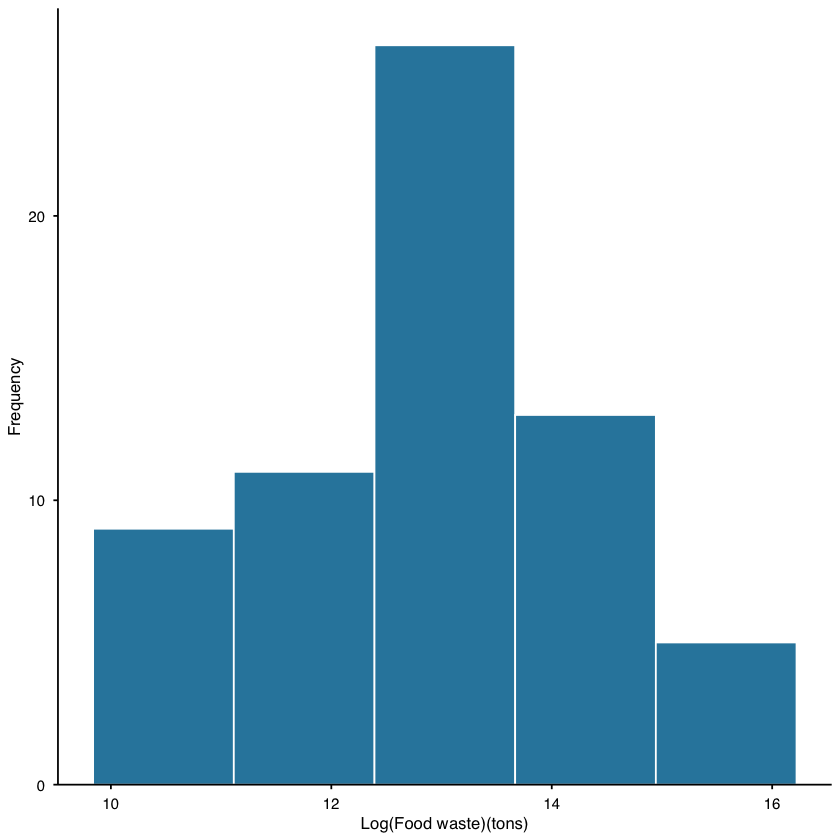

In [25]:
# Science journal-compliant histogram
p_hist <- ggplot(df_chart, aes(x = log_food_tons)) +
    geom_histogram(
        fill = "#2E86AB", # Blue (avoid red/green, avoid grayscale)
        color = "white",
        bins = 5, # More bins for better data representation
        linewidth = 0.5 # Minimum 0.5 point line width
    ) +
    labs(
        x = "Log(Food waste)(tons)", # Variable in italics, units in parentheses
        y = "Frequency" # Capitalize only first letter
    ) +
    # Remove explicit limits - let ggplot auto-scale (won't extend beyond data)
    scale_y_continuous(
        expand = expansion(mult = c(0, 0.05)) # Start at 0, small padding at top
    ) +
    theme_minimal(base_family = "Helvetica") +
    theme(
        # Remove title (goes in caption)
        plot.title = element_blank(),
        plot.subtitle = element_blank(),

        # Font sizes: 7pt minimum after reduction (use ~10pt for 1.4x reduction)
        text = element_text(family = "Helvetica", size = 10, color = "black"),
        axis.text = element_text(size = 9, color = "black"),
        axis.title = element_text(size = 10, color = "black"),

        # Axis formatting
        axis.line = element_line(color = "black", linewidth = 0.5),
        axis.ticks = element_line(color = "black", linewidth = 0.5),

        # Remove minor tick marks and grid lines
        panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),

        # Minimize margins
        plot.margin = margin(5, 5, 5, 5, "pt"),

        # Background
        panel.background = element_rect(fill = "white", color = NA),
        plot.background = element_rect(fill = "white", color = NA)
    )

print(p_hist)

# # Save as vector PDF for Science submission
# ggsave(
#   "histogram_log_food_tons.pdf",
#   p_hist,
#   width = 12.1,  # cm (2-column width)
#   height = 8,    # cm (adjust as needed)
#   units = "cm",
#   device = cairo_pdf  # Vector format
# )

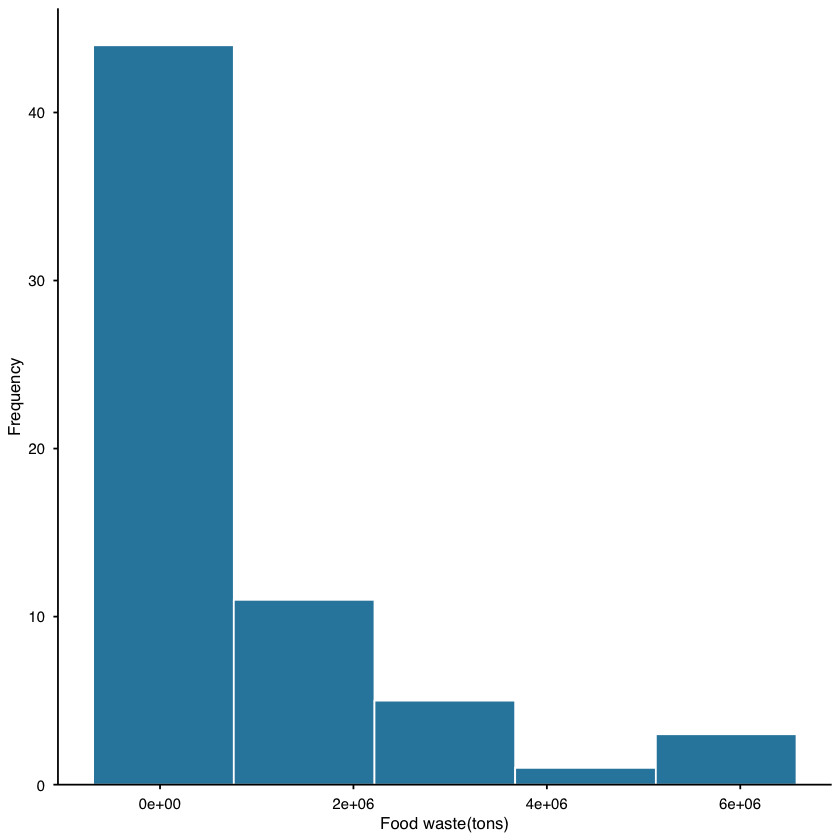

In [24]:
# Science journal-compliant histogram
p_hist <- ggplot(df_chart, aes(x = food_tons_clean)) +
  geom_histogram(
    fill = "#2E86AB",  # Blue (avoid red/green, avoid grayscale)
    color = "white",
    bins = 5,  # More bins for better data representation
    linewidth = 0.5  # Minimum 0.5 point line width
  ) +
  labs(
    x = "Food waste(tons)",  # Variable in italics, units in parentheses
    y = "Frequency"  # Capitalize only first letter
  ) +
  # Remove explicit limits - let ggplot auto-scale (won't extend beyond data)
  scale_y_continuous(
    expand = expansion(mult = c(0, 0.05))  # Start at 0, small padding at top
  ) +
  theme_minimal(base_family = "Helvetica") +
  theme(
    # Remove title (goes in caption)
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    
    # Font sizes: 7pt minimum after reduction (use ~10pt for 1.4x reduction)
    text = element_text(family = "Helvetica", size = 10, color = "black"),
    axis.text = element_text(size = 9, color = "black"),
    axis.title = element_text(size = 10, color = "black"),
    
    # Axis formatting
    axis.line = element_line(color = "black", linewidth = 0.5),
    axis.ticks = element_line(color = "black", linewidth = 0.5),
    
    # Remove minor tick marks and grid lines
    panel.grid.minor = element_blank(),
    panel.grid.major = element_blank(),
    
    # Minimize margins
    plot.margin = margin(5, 5, 5, 5, "pt"),
    
    # Background
    panel.background = element_rect(fill = "white", color = NA),
    plot.background = element_rect(fill = "white", color = NA)
  )

print(p_hist)

# # Save as vector PDF for Science submission
# ggsave(
#   "histogram_log_food_tons.pdf",
#   p_hist,
#   width = 12.1,  # cm (2-column width)
#   height = 8,    # cm (adjust as needed)
#   units = "cm",
#   device = cairo_pdf  # Vector format
# )

## Observation Count by Year and Policy

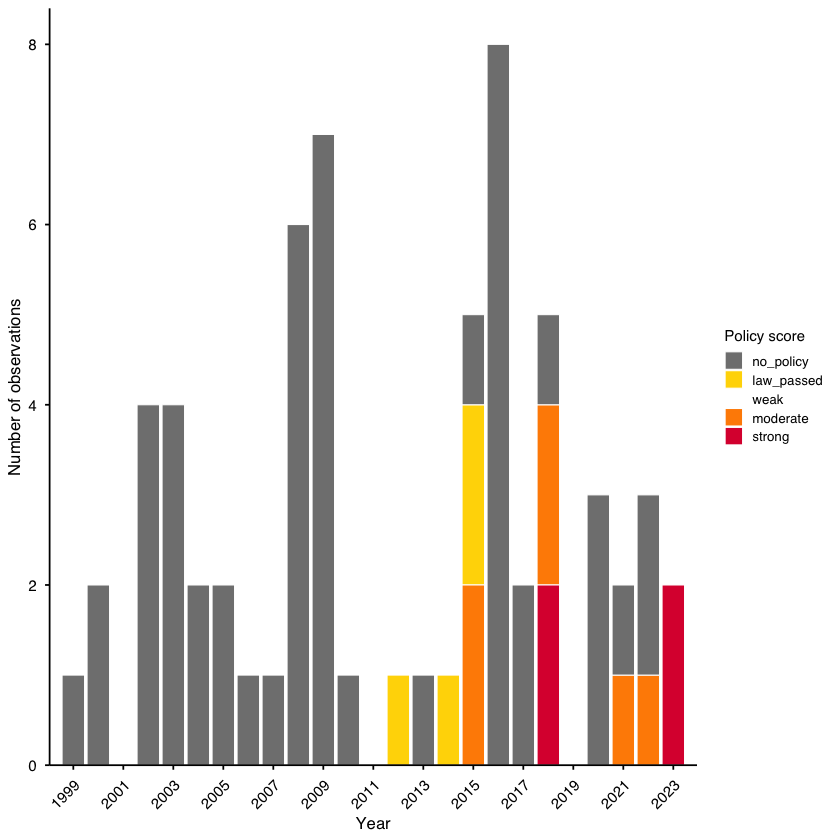

In [27]:
# Create stacked bar chart: observations by year, colored by score
# First, prepare the data
chart_data <- df_chart %>%
  group_by(year, score) %>%
  summarise(count = n(), .groups = "drop") %>%
  ungroup()

# Ensure score is a factor with consistent ordering
score_order <- c("no_policy", "law_passed", "weak", "moderate", "strong")
chart_data$score <- factor(chart_data$score, levels = score_order)

# Science journal-compliant stacked bar chart
p_year_score <- ggplot(chart_data, aes(x = year, y = count, fill = score)) +
  geom_bar(stat = "identity", position = "stack", 
           color = "white", linewidth = 0.3) +
  labs(
    x = "Year",
    y = "Number of observations",
    fill = "Policy score"  # Legend title
  ) +
  scale_fill_manual(
    values = c(
      "no_policy" = "#808080",      # Medium gray (more visible)
      "law_passed" = "#FFD700",      # Yellow
      "weak" = "#FFA500",             # Orange (moved to weak)
      "moderate" = "#FF8C00",         # Dark orange
      "strong" = "#DC143C"            # Crimson red
    ),
    na.value = "gray50",
    drop = FALSE  # Keep all levels even if not present
  ) +
  scale_x_continuous(
    breaks = seq(min(chart_data$year, na.rm = TRUE), 
                 max(chart_data$year, na.rm = TRUE), by = 2),
    expand = expansion(mult = 0.02)
  ) +
  scale_y_continuous(
    expand = expansion(mult = c(0, 0.05)),
    breaks = scales::pretty_breaks()
  ) +
  theme_minimal(base_family = "Helvetica") +
  theme(
    plot.title = element_blank(),
    plot.subtitle = element_blank(),
    text = element_text(family = "Helvetica", size = 10, color = "black"),
    axis.text = element_text(size = 9, color = "black"),
    axis.text.x = element_text(angle = 45, hjust = 1),  # Rotate x-axis labels
    axis.title = element_text(size = 10, color = "black"),
    axis.line = element_line(color = "black", linewidth = 0.5),
    axis.ticks = element_line(color = "black", linewidth = 0.5),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_blank(),  # Remove grid lines per Science requirements
    plot.margin = margin(5, 5, 5, 5, "pt"),
    panel.background = element_rect(fill = "white", color = NA),
    plot.background = element_rect(fill = "white", color = NA),
    legend.position = "right",
    legend.title = element_text(size = 9),
    legend.text = element_text(size = 8),
    legend.key.size = unit(0.4, "cm")
  )

print(p_year_score)

# Save as vector PDF for Science submission
ggsave(
  "observations_by_year_score.pdf",
  p_year_score,
  width = 12.1,  # cm (2-column width)
  height = 8,    # cm
  units = "cm",
  device = cairo_pdf
)

In [38]:
# Create table and export to CSV - only rename columns that exist
table_data <- df_chart %>%
    group_by(year, score) %>%
    summarise(count = n(), .groups = "drop") %>%
    ungroup() %>%
    pivot_wider(names_from = score, values_from = count, values_fill = 0) %>%
    arrange(year) %>%
    mutate(total = rowSums(select(., -year), na.rm = TRUE))

# Check what columns actually exist
print("Columns in table_data:")
print(names(table_data))

# Rename only columns that exist
col_rename_map <- list(
    Year = "year",
    `No policy` = "no_policy",
    `Law passed` = "law_passed",
    Weak = "weak",
    Moderate = "moderate",
    Strong = "strong",
    Total = "total"
)

# Only keep rename mappings for columns that exist
col_rename_map <- col_rename_map[names(col_rename_map) %in% names(table_data) |
    col_rename_map %in% names(table_data)]

# Apply rename only for existing columns
for (new_name in names(col_rename_map)) {
    old_name <- col_rename_map[[new_name]]
    if (old_name %in% names(table_data)) {
        table_data <- table_data %>% rename(!!new_name := !!old_name)
    }
}

# Export to CSV
write.csv(table_data, "/Users/aschharwood/kedro_policy_2/final_paper_analysis/tables/observations_by_year_score.csv", row.names = FALSE)

# Print it
print(table_data)

[1] "Columns in table_data:"
[1] "year"       "no_policy"  "law_passed" "moderate"   "strong"    
[6] "total"     
# A tibble: 22 × 6
    Year `No policy` `Law passed` Moderate Strong Total
   <int>       <int>        <int>    <int>  <int> <dbl>
 1  1999           1            0        0      0     1
 2  2000           2            0        0      0     2
 3  2002           4            0        0      0     4
 4  2003           4            0        0      0     4
 5  2004           2            0        0      0     2
 6  2005           2            0        0      0     2
 7  2006           1            0        0      0     1
 8  2007           1            0        0      0     1
 9  2008           6            0        0      0     6
10  2009           7            0        0      0     7
# ℹ 12 more rows


In [39]:
# Long format: State, Year, Score, Count
table_long <- df_chart %>%
    group_by(state, year, score) %>%
    summarise(count = n(), .groups = "drop") %>%
    ungroup() %>%
    arrange(state, year, score) %>%
    rename(
        State = state,
        Year = year,
        Score = score,
        Count = count
    )

# Export to CSV
write.csv(table_long, "/Users/aschharwood/kedro_policy_2/final_paper_analysis/tables/observations_by_state_year_score_long.csv", row.names = FALSE)

print(head(table_long, 20))

# A tibble: 20 × 4
   State          Year Score      Count
   <chr>         <int> <chr>      <int>
 1 california     1999 no_policy      1
 2 california     2003 no_policy      1
 3 california     2008 no_policy      2
 4 california     2014 law_passed     1
 5 california     2018 moderate       2
 6 california     2021 moderate       1
 7 connecticut    2009 no_policy      2
 8 connecticut    2015 moderate       2
 9 delaware       2016 no_policy      2
10 georgia        2004 no_policy      2
11 illinois       2008 no_policy      2
12 indiana        2008 no_policy      1
13 iowa           2016 no_policy      2
14 iowa           2022 no_policy      2
15 maine          2007 no_policy      1
16 massachusetts  2002 no_policy      1
17 massachusetts  2010 no_policy      1
18 massachusetts  2022 moderate       1
19 michigan       2015 no_policy      1
20 minnesota      2013 no_policy      1
